# Programming Assignment

## Language model for the Shakespeare dataset

### Instructions

In this notebook, you will use the text preprocessing tools and RNN models to build a character-level language model. You will then train your model on the works of Shakespeare, and use the network to generate your own text..

Some code cells are provided you in the notebook. You should avoid editing provided code, and make sure to execute the cells in order to avoid unexpected errors. Some cells begin with the line: 

`#### GRADED CELL ####`

Don't move or edit this first line - this is what the automatic grader looks for to recognise graded cells. These cells require you to write your own code to complete them, and are automatically graded when you submit the notebook. Don't edit the function name or signature provided in these cells, otherwise the automatic grader might not function properly. Inside these graded cells, you can use any functions or classes that are imported below, but make sure you don't use any variables that are outside the scope of the function.

### How to submit

Complete all the tasks you are asked for in the worksheet. When you have finished and are happy with your code, press the **Submit Assignment** button at the top of this notebook.

### Let's get started!

We'll start running some imports, and loading the dataset. Do not edit the existing imports in the following cell. If you would like to make further Tensorflow imports, you should add them here.

In [1]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. Do not make any imports elsewhere in the notebook

import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline

# If you would like to make further imports from tensorflow, add them here



![Shakespeare image](data/shakespeare.png)

#### The Shakespeare dataset

In this assignment, you will use a subset of the [Shakespeare dataset](http://shakespeare.mit.edu). It consists of a single text file with several excerpts concatenated together. The data is in raw text form, and so far has not yet had any preprocessing. 

Your goal is to construct an unsupervised character-level sequence model that can generate text according to a distribution learned from the dataset.

#### Load and inspect the dataset

In [2]:
# Load the text file into a string

with open('data/Shakespeare.txt', 'r', encoding='utf-8') as file:
    text = file.read()

In [3]:
# Create a list of chunks of text

text_chunks = text.split('.')

To give you a feel for what the text looks like, we will print a few chunks from the list.

In [4]:
# Display some randomly selected text samples

num_samples = 5
inx = np.random.choice(len(text_chunks), num_samples, replace=False)
for chunk in np.array(text_chunks)[inx]:
    print(chunk)



KING RICHARD III:
Who intercepts my expedition?

DUCHESS OF YORK:
O, she that might have intercepted thee,
By strangling thee in her accursed womb
From all the slaughters, wretch, that thou hast done!

QUEEN ELIZABETH:
Hidest thou that forehead with a golden crown,
Where should be graven, if that right were right,
The slaughter of the prince that owed that crown,
And the dire death of my two sons and brothers?
Tell me, thou villain slave, where are my children?

DUCHESS OF YORK:
Thou toad, thou toad, where is thy brother Clarence?
And little Ned Plantagenet, his son?

QUEEN ELIZABETH:
Where is kind Hastings, Rivers, Vaughan, Grey?

KING RICHARD III:
A flourish, trumpets! strike alarum, drums!
Let not the heavens hear these tell-tale women
Rail on the Lord's enointed: strike, I say!
Either be patient, and entreat me fair,
Or with the clamorous report of war
Thus will I drown your exclamations
 Affrighted much,
I did in time collect myself and thought
This was so and no slumber

March 

#### Create a character-level tokenizer

You should now write a function that returns a `Tokenizer` object. The function takes a list of strings as an argument, and should create a `Tokenizer` according to the following specification:

* The number of tokens should be unlimited (there should be as many as required by the dataset).
* Tokens should be created at the character level (not at the word level, which is the default behaviour).
* No characters should be filtered out or ignored.
* The original capitalization should be retained (do not convert the text to lower case)

The `Tokenizer` should be fit to the `list_of_strings` argument and returned by the function. 

**Hint:** you may need to refer to the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) for the `Tokenizer`.

In [5]:
#### GRADED CELL ####

# Complete the following function.
# Make sure not to change the function name or arguments.

def create_character_tokenizer(list_of_strings):
    """
    This function takes a list of strings as its argument. It should create 
    and return a Tokenizer according to the above specifications. 
    """
    from tensorflow.keras.preprocessing.text import Tokenizer
    tokenizer = Tokenizer(char_level= True, filters="", lower=False)
    tokenizer.fit_on_texts(list_of_strings)
    return tokenizer
    

In [6]:
# Get the tokenizer

tokenizer = create_character_tokenizer(text_chunks)

#### Tokenize the text

You should now write a function to use the tokenizer to map each string in `text_chunks` to its corresponding encoded sequence. The following function takes a fitted `Tokenizer` object in the first argument (as returned by `create_character_tokenizer`) and a list of strings in the second argument. The function should return a list of lists, where each sublist is a sequence of integer tokens encoding the text sequences according to the mapping stored in the tokenizer.

**Hint:** you may need to refer to the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) for the `Tokenizer`.

In [7]:
#### GRADED CELL ####

# Complete the following function.
# Make sure not to change the function name or arguments.

def strings_to_sequences(tokenizer, list_of_strings):
    """
    This function takes a tokenizer object and a list of strings as its arguments.
    It should use the tokenizer to map the text chunks to sequences of tokens and
    then return this list of encoded sequences.
    """
    return tokenizer.texts_to_sequences(list_of_strings)
    
    
    

In [8]:
# Encode the text chunks into tokens

seq_chunks = strings_to_sequences(tokenizer, text_chunks)

#### Pad the encoded sequences and store them in a numpy array

Since not all of the text chunks are the same length, you will need to pad them in order to train on batches. You should now complete the following function, which takes the list of lists of tokens, and creates a single numpy array with the token sequences in the rows, according to the following specification:

* The longest allowed sequence should be 500 tokens. Any sequence that is longer should be shortened by truncating the beginning of the sequence.
* Use zeros for padding the sequences. The zero padding should be placed before the sequences as required.

The function should then return the resulting numpy array.

**Hint:** you may want to refer to the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) for the `pad_sequences` function.

In [9]:
#### GRADED CELL ####

# Complete the following function.
# Make sure not to change the function name or arguments.

def make_padded_dataset(sequence_chunks):
    """
    This function takes a list of lists of tokenized sequences, and transforms
    them into a 2D numpy array, padding the sequences as necessary according to
    the above specification. The function should then return the numpy array.
    """
    
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    return pad_sequences(sequence_chunks, maxlen=500, padding="pre", truncating="pre")
    

In [10]:
# Pad the token sequence chunks and get the numpy array

padded_sequences = make_padded_dataset(seq_chunks)
padded_sequences.shape

(7886, 500)

#### Create model inputs and targets

Now you are ready to build your RNN model. The model will receive a sequence of characters and predict the next character in the sequence. At training time, the model can be passed an input sequence, with the target sequence is shifted by one.

For example, the expression `To be or not to be` appears in Shakespeare's play 'Hamlet'. Given input `To be or not to b`, the correct prediction is `o be or not to be`. Notice that the prediction is the same length as the input!

![sequence_prediction_example](data/rnn_example.png)

You should now write the following function to create an input and target array from the current `padded_sequences` array. The function has a single argument that is a 2D numpy array of shape `(num_examples, max_seq_len)`. It should fulfil the following specification:

* The function should return an input array and an output array, both of size `(num_examples, max_seq_len - 1)`.
* The input array should contain the first `max_seq_len - 1` tokens of each sequence. 
* The output array should contain the last `max_seq_len - 1` tokens of each sequence. 

The function should then return the tuple `(input_array, output_array)`. Note that it is possible to complete this function using numpy indexing alone!

In [11]:
#### GRADED CELL ####

# Complete the following function.
# Make sure not to change the function name or arguments.

def create_inputs_and_targets(array_of_sequences):
    """
    This function takes a 2D numpy array of token sequences, and returns a tuple of two
    elements: the first element is the input array and the second element is the output
    array, which are defined according to the above specification.
    """   
    return array_of_sequences[:,:-1], array_of_sequences[:,1:]
    
    

In [12]:
# Create the input and output arrays

input_seq, target_seq = create_inputs_and_targets(padded_sequences)

#### Preprocess sequence array for stateful RNN

We will build our RNN language model to be stateful, so that the internal state of the RNN will be maintained across batches. For this to be effective, we need to make sure that each element of every batch follows on from the corresponding element of the preceding batch (you may want to look back at the "Stateful RNNs" reading notebook earlier in the week).

The following code processes the input and output sequence arrays so that they are ready to be split into batches for training a stateful RNN, by re-ordering the sequence examples (the rows) according to a specified batch size. 

In [13]:
# Fix the batch size for training

batch_size = 32

In [14]:
# Prepare input and output arrays for training the stateful RNN

num_examples = input_seq.shape[0]

num_processed_examples = num_examples - (num_examples % batch_size)

input_seq = input_seq[:num_processed_examples]
target_seq = target_seq[:num_processed_examples]

steps = int(num_processed_examples / 32)  # steps per epoch

inx = np.empty((0,), dtype=np.int32)
for i in range(steps):
    inx = np.concatenate((inx, i + np.arange(0, num_processed_examples, steps)))

input_seq_stateful = input_seq[inx]
target_seq_stateful = target_seq[inx]

#### Split the data into training and validation sets

We will set aside approximately 20% of the data for validation.

In [15]:
# Create the training and validation splits

num_train_examples = int(batch_size * ((0.8 * num_processed_examples) // batch_size))

input_train = input_seq_stateful[:num_train_examples]
target_train = target_seq_stateful[:num_train_examples]

input_valid = input_seq_stateful[num_train_examples:]
target_valid = target_seq_stateful[num_train_examples:]

#### Create training and validation Dataset objects

You should now write a function to take the training and validation input and target arrays, and create training and validation `tf.data.Dataset` objects. The function takes an input array and target array in the first two arguments, and the batch size in the third argument. Your function should do the following:

* Create a `Dataset` using the `from_tensor_slices` static method, passing in a tuple of the input and output numpy arrays.
* Batch the `Dataset` using the `batch_size` argument, setting `drop_remainder` to `True`. 

The function should then return the `Dataset` object.

In [16]:
#### GRADED CELL ####

# Complete the following function.
# Make sure not to change the function name or arguments.

def make_Dataset(input_array, target_array, batch_size):
    """
    This function takes two 2D numpy arrays in the first two arguments, and an integer
    batch_size in the third argument. It should create and return a Dataset object 
    using the two numpy arrays and batch size according to the above specification.
    """
    import tensorflow
    return tensorflow.data.Dataset.from_tensor_slices((input_array, target_array)).batch(batch_size, drop_remainder = True)
    
    

In [17]:
# Create the training and validation Datasets

train_data = make_Dataset(input_train, target_train, batch_size)
valid_data = make_Dataset(input_valid, target_valid, batch_size)

#### Build the recurrent neural network model

You are now ready to build your RNN character-level language model. You should write the following function to build the model; the function takes arguments for the batch size and vocabulary size (number of tokens). Using the Sequential API, your function should build your model according to the following specifications:

* The first layer should be an Embedding layer with an embedding dimension of 256 and set the vocabulary size to `vocab_size` from the function argument.
* The Embedding layer should also mask the zero padding in the input sequences.
* The Embedding layer should also set the `batch_input_shape` to `(batch_size, None)` (a fixed batch size is required for stateful RNNs).
* The next layer should be a (uni-directional) GRU layer with 1024 units, set to be a stateful RNN layer.
* The GRU layer should return the full sequence, instead of just the output state at the final time step.
* The final layer should be a Dense layer with `vocab_size` units and no activation function.

In total, the network should have 3 layers.

In [18]:
#### GRADED CELL ####

# Complete the following function.
# Make sure not to change the function name or arguments.

def get_model(vocab_size, batch_size):
    """
    This function takes a vocabulary size and batch size, and builds and returns a 
    Sequential model according to the above specification.
    """
    import tensorflow as tf
    return tf.keras.models.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=256,batch_input_shape = (batch_size, None)),
        tf.keras.layers.Masking(),
        tf.keras.layers.GRU(units=1024, stateful=True, return_sequences=True),
        tf.keras.layers.Dense(units=vocab_size)
    ])
    
    

In [19]:
# Build the model and print the model summary

model = get_model(len(tokenizer.word_index) + 1, batch_size)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 256)           16640     
_________________________________________________________________
masking (Masking)            (32, None, 256)           0         
_________________________________________________________________
gru (GRU)                    (32, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (32, None, 65)            66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


#### Compile and train the model

You are now ready to compile and train the model. For this model and dataset, the training time is very long. Therefore for this assignment it is not a requirement to train the model. We have pre-trained a model for you (using the code below) and saved the model weights, which can be loaded to get the model predictions. 

It is recommended to use accelerator hardware (e.g. using Colab) when training this model. It would also be beneficial to increase the size of the model, e.g. by stacking extra recurrent layers.

In [22]:
# Choose whether to train a new model or load the pre-trained model

skip_training = True

In [23]:
# Compile and train the model, or load pre-trained weights

if not skip_training:
    checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath='./models/ckpt',
                                                           save_weights_only=True,
                                                           save_best_only=True)
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['sparse_categorical_accuracy'])
    history = model.fit(train_data, epochs=15, validation_data=valid_data, 
                        validation_steps=50, callbacks=[checkpoint_callback])

In [24]:
# Save model history as a json file, or load it if using pre-trained weights

if not skip_training:
    history_dict = dict()
    for k, v in history.history.items():
        history_dict[k] = [float(val) for val in history.history[k]]
    with open('models/history.json', 'w+') as json_file:
        json.dump(history_dict, json_file, sort_keys=True, indent=4)
else:
    with open('models/history.json', 'r') as json_file:
        history_dict = json.load(json_file)

#### Plot the learning curves

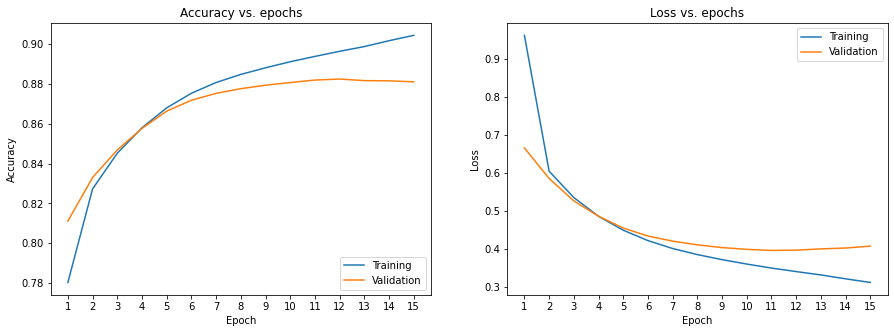

In [25]:
# Run this cell to plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history_dict['sparse_categorical_accuracy'])
plt.plot(history_dict['val_sparse_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(len(history_dict['sparse_categorical_accuracy'])))
ax = plt.gca()
ax.set_xticklabels(1 + np.arange(len(history_dict['sparse_categorical_accuracy'])))
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(len(history_dict['sparse_categorical_accuracy'])))
ax = plt.gca()
ax.set_xticklabels(1 + np.arange(len(history_dict['sparse_categorical_accuracy'])))
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

#### Write a text generation algorithm

You can now use the model to generate text! In order to generate a single text sequence, the model needs to be rebuilt with a batch size of 1.

In [26]:
# Re-build the model and load the saved weights

model = get_model(len(tokenizer.word_index) + 1, batch_size=1)
model.load_weights(tf.train.latest_checkpoint('./models/'))

An algorithm to generate text is as follows:

1. Specify a seed string (e.g. `'ROMEO:'`) to get the network started, and a define number of characters for the model to generate, `num_generation_steps`.
2. Tokenize this sentence to obtain a list containing one list of the integer tokens.
3. Reset the initial state of the network. 
4. Convert the token list into a Tensor (or numpy array) and pass it to your model as a batch of size one.
5. Get the model prediction (logits) for the last time step and extract the state of the recurrent layer.
6. Use the logits to construct a categorical distribution and sample a token from it.
7. Repeat the following for `num_generation_steps - 1` steps:

    1. Use the saved state of the recurrent layer and the last sampled token to get new logit predictions
    2. Use the logits to construct a new categorical distribution and sample a token from it.
    3. Save the updated state of the recurrent layer.    

8. Take the final list of tokens and convert to text using the Tokenizer.

Note that the internal state of the recurrent layer can be accessed using the `states` property. For the GRU layer, it is a list of one variable:

In [27]:
# Inspect the model's current recurrent state

model.layers[2].states

[<tf.Variable 'gru_1/Variable:0' shape=(1, 1024) dtype=float32, numpy=array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>]

We will break the algorithm down into two steps. First, you should now complete the following function that takes a sequence of tokens of any length and returns the model's prediction (the logits) for the last time step. The specification is as follows:

* The token sequence will be a python list, containing one list of integer tokens, e.g. `[[1, 2, 3, 4]]`
* The function should convert the list into a 2D Tensor or numpy array
* If the function argument `initial_state` is `None`, then the function should reset the state of the recurrent layer to zeros.
* Otherwise, if the function argument `initial_state` is a 2D Tensor or numpy array, assign the value of the internal state of the GRU layer to this argument.
* Get the model's prediction (logits) for the last time step only.

The function should then return the logits as a 2D numpy array, where the first dimension is equal to 1 (batch size).

**Hint:** the internal state of the recurrent can be reset to zeros using the `reset_states` method.

In [33]:
#### GRADED CELL ####

# Complete the following function.
# Make sure not to change the function name or arguments.

def get_logits(model, token_sequence, initial_state=None):
    """
    This function takes a model object, a token sequence and an optional initial
    state for the recurrent layer. The function should return the logits prediction
    for the final time step as a 2D numpy array.
    """
    if initial_state is None:
        model.layers[2].state = np.zeros(model.layers[2].states[0].shape)
    else:
        model.layers[2].state = initial_state
    return model.predict(token_sequence)[0][-1].reshape((len(token_sequence),-1))
    
        
        

In [34]:
# Test the get_logits function by passing a dummy token sequence

dummy_initial_state = tf.random.normal(model.layers[2].states[0].shape)
get_logits(model, [[1, 2, 3, 4]], initial_state=dummy_initial_state)

array([[ 3.1837602 ,  1.0346217 ,  2.6227455 ,  3.6633284 ,  2.8442175 ,
         0.6151367 , -3.502679  ,  4.7288704 ,  6.6962037 ,  6.800436  ,
         1.629855  ,  3.1233442 ,  4.116008  ,  1.4024609 ,  6.517677  ,
         5.369602  ,  0.45096406,  2.450462  ,  4.3943815 ,  1.6517957 ,
         1.6883885 , -0.38567495, -8.962388  ,  3.2745848 ,  3.8579504 ,
         0.529955  , -8.989223  ,  1.2769482 ,  0.29523534, -5.6884456 ,
         2.3418884 , -7.9921584 , -8.691313  , -4.482049  , -2.6258905 ,
        -7.193611  , -4.743625  , -8.451079  ,  0.76059645, -5.965231  ,
        -7.4977794 , -7.336135  , -4.0108547 , -5.2444544 ,  1.2837523 ,
        -6.790062  ,  1.8976549 , -8.404305  , -0.3808067 , -7.457829  ,
        -5.3949475 , -6.2316017 , -8.783675  , -8.673455  , -3.6530302 ,
        -1.6375995 , -0.03997967,  0.7070605 , -7.469277  , -8.240738  ,
        -5.254208  , -6.276511  , -8.802983  , -6.0984755 , -7.1233387 ]],
      dtype=float32)

You should now write a function that takes a logits prediction similar to the above, uses it to create a categorical distribution, and samples a token from this distribution. The following function takes a 2D numpy array `logits` as an argument, and should return a single integer prediction that is sampled from the categorical distribution. 

**Hint:** you might find the `tf.random.categorical` function useful for this; see the documentation [here](https://www.tensorflow.org/api_docs/python/tf/random/categorical).

In [35]:
#### GRADED CELL ####

# Complete the following function.
# Make sure not to change the function name or arguments.

def sample_token(logits):
    """
    This function takes a 2D numpy array as an input, and constructs a 
    categorical distribution using it. It should then sample from this
    distribution and return the sample as a single integer.
    """
    return tf.random.categorical(logits, num_samples = 1)[0,0].numpy()
    
    
    

In [36]:
# Test the sample_token function by passing dummy logits

dummy_initial_state = tf.random.normal(model.layers[2].states[0].shape)
dummy_logits = get_logits(model, [[1, 2, 3, 4]], initial_state=dummy_initial_state)
sample_token(dummy_logits)

8

In [37]:
logits_size = dummy_logits.shape[1]
dummy_logits = -np.inf*np.ones((1, logits_size))
dummy_logits[0, 20] = 0
sample_token(dummy_logits)
random_inx = np.random.choice(logits_size, 2, replace=False)
random_inx1, random_inx2 = random_inx[0], random_inx[1]
print(random_inx1, random_inx2)
dummy_logits = -np.inf*np.ones((1, logits_size))
dummy_logits[0, random_inx1] = 0
dummy_logits[0, random_inx2] = 0
sampled_token = []
for _ in range(100):
    sampled_token.append(sample_token(dummy_logits))
    
l_tokens, l_counts = np.unique(np.array(sampled_token), return_counts=True)
len(l_tokens) == 2

56 28


True

#### Generate text from the model

You are now ready to generate text from the model!

In [50]:
# Create a seed string and number of generation steps

init_string = 'ROMEO:'
num_generation_steps = 500

In [51]:
# Use the model to generate a token sequence

token_sequence = tokenizer.texts_to_sequences([init_string])

initial_state = None
input_sequence = token_sequence

for i in range(num_generation_steps):
    print(i)
    print("input_sequence",input_sequence)
    logits = get_logits(model, input_sequence, initial_state=initial_state)
    print(logits)
    sampled_token = sample_token(logits)
    
    print(sampled_token)
    token_sequence[0].append(sampled_token)
    print("token_sequence:")
    print(token_sequence)
    input_sequence = token_sequence
    print('input_sequence:')
    print(input_sequence)
    initial_state = model.layers[2].states[0].numpy()
    print(tokenizer.index_word[sampled_token])
    
print(tokenizer.sequences_to_texts(token_sequence)[0][::2])

0
input_sequence [[34, 32, 42, 31, 32, 25]]
[[  5.342728    11.2559395   -0.6893883    1.1843344   -2.0926805
   -2.0769546   -2.28671      3.9158392   -2.8868854    1.8868436
   -0.10655984   9.350081     1.3814667   -0.7538172   -0.94363534
   -0.7052189   -1.6653951    5.471114    -0.72750807   0.04753439
   -3.3734572   -2.6277287   -5.0946927   -0.7635193   -4.239142
    5.4462004   -4.9216785   -3.1341102   -3.71768     -3.8010933
    7.2329006   -5.329161    -6.09832     -3.7619643   -8.143152
   -5.2083406   -6.6886377   -8.673479     5.2176504   -5.533539
   -3.4551265   -8.590673    -9.372917    -5.3554177    3.0025172
   -7.464106     3.5700955   -4.1224318    6.0478888   -5.5653334
   -6.2412887   -6.716017   -10.008962    -6.7352505   -6.2930093
   -5.066732    -3.6706486   -1.5185262   -7.7867923   -8.916347
    0.29370764  -3.0923574   -5.8486686   -7.088737    -6.526989  ]]
1
token_sequence:
[[34, 32, 42, 31, 32, 25, 1]]
input_sequence:
[[34, 32, 42, 31, 32, 25, 1]]
 
1

[[  4.5520606   -0.7834982    8.219168     1.7320466   10.647969
    6.8627725   11.72779     -1.5533082    7.1785913    0.9706372
    7.2676463    1.0939738    4.51209     -3.8591988    5.154328
   -0.3183919    5.295527    -0.77869654   6.504552    -2.9309142
    1.6604747   -0.8475628   -2.8521876   -0.07498903  -1.9730337
   -0.62194866  -4.437561    -2.0284483   -2.2219353   -8.378444
   -0.5457698   -3.5654383   -2.557571   -10.425806    -2.3409636
   -5.6134443   -4.789951    -3.362934    -0.7631251   -4.1057415
   -7.3646793   -1.9287287   -4.58799     -5.8527102   -2.164079
   -4.4936285   -1.221386    -7.733843    -2.125038    -4.608678
   -6.550043    -6.077359    -7.312718    -4.6684437   -2.9260392
   -0.6717062   -3.6863697   -4.5547104   -3.1306505   -4.132585
   -5.048959    -5.689133    -7.8471484   -5.4463162   -5.5094943 ]]
6
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6]]
input_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 

[[ -0.13191402  10.571838     2.8078485    8.261125     2.0236323
    2.794772     3.436992     2.491966    -3.3994033   -1.5823588
    3.4260235    6.2229366    1.9345217   -2.6492574    1.5274681
    2.3182943    0.2874557    6.221439     1.2418718   -0.04177203
    2.4628685   -1.3025516   -4.0271697    2.6306043    2.1036875
    5.112836    -3.1651332   -6.3918724   -0.5012286   -4.1461205
    4.750131    -6.8735414   -4.4466558   -8.462133    -8.660318
   -8.195346    -6.609592    -5.3313065    5.595339    -3.5018384
   -6.2786865   -4.281579    -6.862831    -5.1800447    4.219831
   -5.8640966    3.3680677   -7.5960875    4.2370787   -6.7826986
   -5.915547    -6.9399123   -8.529101    -8.695387    -6.716451
   -1.5485754  -11.015546    -7.9111176   -8.74265    -10.158646
   -4.8468404   -8.2435665   -8.7297945   -8.612133    -9.465646  ]]
1
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1]]
input_sequence:
[[34, 32, 42, 3

[[ -7.9714723   -5.1890745    3.3443346    5.8291144    3.6330385
    4.7113843    4.100212     3.998596     1.5490199    3.2095916
    5.047767   -10.725406     4.246517     2.4500103    3.7737658
    4.6566286    3.8724675   -5.3300285    4.134038     3.839926
    3.4879951    2.696925     4.533046     4.699402     3.556514
   -6.406543     2.5030353    2.6358657    1.5357277    0.33468813
    3.273428     1.7741476    1.2036133   -1.5356907    0.8286215
    1.2255927    1.9800915    1.3541436   -6.2171707    0.58637625
   -3.7724965    0.4523923    1.6076552    2.0509558   -8.059412
    0.9023078   -6.2038116   -0.30672833  -3.4955046   -1.051962
   -0.24923217   1.4928105    0.4561334   -0.30145586   0.16172183
    1.0253431   -4.3196297   -1.0272847    0.26956457  -4.1201153
   -3.344417    -5.445966    -6.808558    -4.0694885   -5.461076  ]]
3
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1

[[  3.789744    -7.887451     4.6900644    7.099339     2.5495532
    3.905691    -1.728318    10.971594     4.786108     7.143121
    0.64026344 -12.1192045    6.699964     6.4133706    2.6694987
   10.095129    -3.453405    -7.622053     0.91898465   3.4674878
    3.8922193    7.1661286   -6.593466     3.051818     6.024571
   -8.7566595   -9.168434     4.4417367    0.2531945   -3.144252
    1.2799898   -8.845203   -11.643415    -5.92871     -5.73309
   -5.3190155   -7.0331783   -3.9860256   -9.51086     -5.464697
   -9.981876   -10.7527075   -5.5024204   -5.0257807   -7.500941
   -5.8672986   -5.951256    -5.112399    -7.277455    -7.7773695
   -7.6904893   -3.8274596   -5.9107933   -7.75444      0.4779595
   -0.6435292    3.982452     1.0299159   -3.8241563   -8.884191
  -12.118786    -8.256784    -8.640735    -6.334653    -7.3891335 ]]
7
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6,

[[ -7.931537    -8.939535     4.0472994    5.247685     4.8170743
    4.6991324    4.1798043    5.4995327    2.8892775    3.6447706
    4.6684947  -11.246148     4.767975     3.0563133    3.2534897
    4.238204     3.5442607   -6.7120895    4.572292     4.521175
    3.948433     4.092526     1.1655663    4.444863     4.2376504
   -7.127327     1.2710248    2.1373737    1.1186004    0.6768504
    1.3675996    0.12471926   0.03767134  -2.5220454    0.97063816
    0.05856839   1.2133923    1.4704756   -6.9489703    1.0490168
   -3.143792     0.5267778    1.2123839    2.1534133   -7.4713664
    0.23277423  -6.296686     0.291354    -3.8016176   -0.71432054
   -1.5150679    1.7259753    0.382376    -0.3513388    1.0118613
    1.7356962   -4.54331     -3.013612     0.9441651   -3.5385933
   -7.0167513   -5.9254413   -6.209293    -3.6118188   -5.9466496 ]]
12
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7

[[-3.962953   0.7523245  5.1804805  5.0494237  1.9425117  6.2141285
  -2.3692732  3.9896524  1.3458737  6.8520885  5.0134797 -3.7702565
   2.3312283  3.6077132 -1.4197913  4.834986   3.7409155 -2.0468187
   4.520547   2.6971962  5.32585    1.6575549 -7.7762165  3.407985
   4.6932855 -3.4648733 -3.5227406  3.7600765  3.0385118 -2.874431
   1.4787356 -3.2052786 -5.2864547 -5.2482214 -4.438996  -2.9261293
  -3.6339295 -5.541051  -2.867225  -3.855636  -1.9915864 -5.931531
  -3.919567  -2.2036836 -4.076466  -5.6301227 -4.9350076 -2.5055225
  -1.686165  -4.707631  -6.5502353 -1.7596897 -6.6688275 -5.3315706
  -3.2118757  0.8284777  1.4873694 -2.5190275 -7.074161  -8.499355
  -6.506793  -5.1791725 -8.940591  -6.494222  -6.8125772]]
15
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4, 27, 2, 13, 1, 7, 3, 8, 2, 15]]
input_sequence:
[[34, 

[[ -3.6439269    5.5082607    3.582466     4.6617446    3.6659408
    3.470682     1.2403926    3.765959     2.2789211    1.2933915
    2.2546313   -2.4333687    4.6431756    9.570314    -1.2191304
    1.6671888    3.5618856    1.7436919    2.4472       3.2669241
    4.3165016    3.8656254   -4.4609575    1.0290059    0.7565096
   -3.8186991   -9.52077      2.4496245    2.4739      -3.8633623
    1.5865198   -4.492612    -7.146009    -4.3160634   -4.726549
   -6.050575    -4.2347155   -4.610465    -3.5360622   -3.6852071
   -6.125818    -6.4767966   -7.049249    -4.0964446   -5.2820716
   -1.8444389   -3.8989072   -5.903534    -1.9359093   -6.2632847
   -5.739825    -5.8329353   -5.036992   -10.623468     0.85487956
    1.5861306   -6.92909     -4.1845655   -4.0241847   -8.11567
   -6.4339075   -6.4088335   -7.8347545   -7.750208    -9.827022  ]]
13
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1

[[-0.9543113   1.9187195   7.483623    0.77599806  7.0033603   6.568954
  -1.714679    2.3845015   1.8598373   1.8708096   8.604794   -3.375336
  -0.83055806 -5.12259     3.6882992   5.4763694   4.1178613   0.70804584
   6.061884    1.7313118  -0.06024969 -2.5909445  -2.3639815   6.56963
   5.7111664  -1.84985    -5.072157    0.30520356 -6.098796   -5.712631
   2.2638562  -0.79618955 -4.2558646  -6.1461773  -2.6853828  -9.5792
  -9.63477    -6.1339984  -1.852785   -3.4769194  -8.048162   -7.5157676
  -7.349407   -3.3492293  -1.826667   -5.6486983  -2.6917515  -7.4746475
  -1.4249264  -6.4341025  -5.7877755  -5.593796   -8.354466   -8.208873
  -0.05093491 -1.4275361  -2.6009119  -3.5060651  -5.573833   -7.6631837
  -6.6189528  -7.79869    -6.633764   -6.657619   -7.781334  ]]
5
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4, 27,

[[ 1.3692292  -0.6878627  11.441653    1.1084936   9.510012    9.312943
   0.70808744  1.5744205   9.232683    1.6392975   8.562924   -5.59657
   8.600376   -0.8256391   9.761965    0.18288106 10.478231   -1.6128796
   2.1672537   1.0831397   1.6407307   0.66787225 -3.0059512   2.7678044
   1.9791882  -3.0956912  -1.2221657   0.8726571  -2.1483376  -6.3434587
   1.850057   -1.1400287  -3.1091225  -8.565152   -0.8854345  -5.7704306
  -4.99659    -6.865555   -4.015786   -2.216936   -2.3900883  -2.2632492
  -4.3729444  -3.1841583  -3.6489244  -4.122863   -5.2684298  -7.660227
  -4.508114   -4.8128657  -4.0774975  -3.046867   -4.371012   -7.9460254
   1.2408849  -0.8410617   0.6837051  -3.4345531  -2.9427495  -3.7167134
  -7.7170873  -6.3318176  -8.162103   -5.243432   -4.6272945 ]]
16
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4

[[  2.4169066   -0.63282627   8.538642     0.6399526    7.7552166
    8.314136    -0.6206832    0.6339726    7.194017     1.3889289
    8.351202    -1.4338509    1.7301759   -2.234477     6.4933915
    2.9375732    6.727167    -2.8028       2.1209176   -0.67231244
   -1.5756909   -2.5863314   -7.034052     0.8812284   -0.9972315
   -3.379526    -4.591014     0.6544662   -1.6524954   -8.5855055
   -0.1448623   -6.3452444   -6.0791326   -8.694449    -4.2833657
   -9.867311    -8.76765    -10.333091    -4.5304613   -7.250008
   -5.0466933  -10.765923   -10.938434    -4.664805    -5.1956553
   -7.1801133   -6.069104    -9.190718    -1.2881986   -8.793178
   -7.033726    -6.716003   -11.011419   -11.920572    -2.9362369
   -4.1989255   -2.2880018   -0.7186199   -8.2359085   -9.258188
   -8.519186    -7.5663986   -9.421617    -7.1887813   -8.161278  ]]
4
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1,

[[  3.2035894    6.7336407    4.9709992    2.5933845    3.2507098
    3.9164581    4.525301     6.724216     1.6388446   -0.25898734
    4.544093     3.8087106    4.5464277   -3.3557463    4.8622065
    2.7006476    3.275764     6.6657352    2.810211     0.41951597
    0.298685    -1.3174601   -6.4190407   -0.31513345  -2.8701704
    4.7033825   -6.0730844   -4.716787    -2.3527713   -8.379159
    4.5727167   -5.0867395   -6.6423087  -10.865419    -6.851119
   -7.820404    -8.513175    -8.084149     4.6971273   -6.443174
   -7.037166    -6.2243357   -7.648508    -5.4862094    2.863701
   -9.5636215    2.94909     -9.686748     3.3454125   -8.339157
   -8.896509    -8.297026    -9.088274    -9.2918      -5.3969774
   -3.2862513   -6.4653215   -5.337905    -7.35995     -9.824353
   -4.4295206   -6.1174374   -9.155869    -8.025418    -8.368712  ]]
46
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 

[[ 12.5385895   14.199455     0.7185195    1.1186765    1.3604027
   -2.6388052   -4.584793     3.467387    -1.6420164    0.9639173
    0.39827728  17.051186    -0.38442487   0.63779914  -2.1831338
   -0.6868047   -2.1994605    7.524449    -0.89550674   2.1707802
   -1.0425571   -2.0545502   -9.323542    -1.1031476   -1.9221513
    4.0993295  -11.958248    -0.7053499   -1.6163414  -10.173409
    9.822909   -12.275101   -11.835466    -9.972765   -10.551628
  -12.285937   -12.465763   -14.484138     5.4417944  -10.723384
  -10.982206   -13.786511   -11.237835    -9.591727     6.8189635
  -10.42352      5.650482    -9.790056    11.715634   -11.765178
  -11.317805   -11.901218   -15.691976   -11.713277    -7.9070125
   -5.1203203   -0.9511224   -3.1327834  -13.25023    -12.886763
   -2.730631    -6.9428797   -8.872666    -8.838388    -8.658903  ]]
11
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3

[[ -3.6163037   -8.239761     6.103955     7.1930656    5.106873
    3.315042    -0.10399231   8.073703    13.004198     5.4244275
    1.5181261  -11.650445     8.652478     6.8540945    1.7646482
    1.4007174    0.83793586  -9.0564375   -0.7757795    5.0963264
    6.536128     4.441091    -1.9942267    2.118606     1.7441795
   -5.874832    -0.61530757   3.058405    -0.02415276   2.8668182
   -2.230176    -1.3830154   -1.2607138   -4.215302     4.228192
   -2.106261    -0.5283896   -0.81837416 -11.877236    -2.9783497
   -2.3484883   -2.4162858   -0.9476293    1.1125395  -11.827687
   -0.99124163  -9.325501    -0.17884508  -9.8659525   -3.2178483
   -3.2427638    0.12546834   0.8665674   -7.7046375   -1.9616822
   -0.8115433   -0.5110676    1.6193966   -2.2458792   -5.999396
   -7.1568656   -6.2816586   -8.261188    -5.363739    -6.595483  ]]
8
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3

[[-1.22364645e+01 -8.36480522e+00  7.46868491e-01  3.65651965e+00
   2.94790530e+00  3.31844521e+00  3.75391412e+00  3.72787738e+00
   3.56420779e+00  4.19475651e+00  3.50321746e+00 -9.57083607e+00
   2.66473150e+00  2.20398530e-01  2.09650230e+00  4.83412552e+00
   3.64904213e+00 -7.49715805e+00  2.74667478e+00  2.71794248e+00
   3.49010897e+00  3.59225845e+00  4.47427940e+00  2.71297646e+00
   3.64565015e+00 -5.07027006e+00  4.38585758e+00  2.47255594e-01
   1.36660826e+00  3.84031892e+00 -6.41063988e-01  2.21498442e+00
   4.96634531e+00  1.95190322e+00  5.06648779e+00  8.48037910e+00
   7.86844635e+00  8.11346722e+00 -8.49747658e+00  6.87992048e+00
   1.72771502e+00  5.81314182e+00  7.18378401e+00  3.89674926e+00
  -8.97573566e+00  6.77003431e+00 -6.61546183e+00  2.77116346e+00
  -5.04870462e+00  3.12952590e+00  3.42709804e+00  6.00407696e+00
   5.77711630e+00  2.60167718e+00  3.37267295e-03 -4.76960242e-01
  -5.63725042e+00 -9.62665737e-01  3.24638152e+00 -6.74300194e-01
  -4.20903

[[-4.374227    2.0944734   5.7632933   2.8825464   7.7678614   6.1432934
  -1.5416414   1.4826384   4.504429   -1.6810375   7.2258596   1.7479078
   4.1183124  -6.616595    5.3329153   3.4818163   1.1879075   2.2891047
   1.1197585   1.0214007  -0.36840636 -4.2324843  -0.7757054   0.5681896
   1.197517    3.1185145   0.39768377 -1.4093398  -5.834628   -3.5303388
   0.75220066 -0.6583705   2.4370668  -3.571975   -1.2598217  -1.6962881
  -0.9429008  -1.6606513   0.8346551   0.95951617 -1.0531299  -1.3560917
  -2.2569947  -0.3513857  -0.57086915 -1.397069    1.1682131  -3.2389445
  -0.4070496  -2.8709812   1.1528733  -1.543068   -4.003966   -4.6208534
  -2.6613052  -2.4404361  -3.8748875  -2.9249842  -3.3115237  -3.375445
  -1.5066913  -1.3608696  -5.4756465  -4.18432    -3.078422  ]]
10
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12

[[  9.397525    10.785103     2.2692394    0.8821199   -0.8242449
   -0.3099898   -0.17786539   3.5662878    0.33362633   2.43083
    0.7345319   17.773481    -0.28129196  -2.4068635   -3.1226192
   -0.8109594   -1.7092597    7.8040314   -2.2210796   -2.6237285
   -3.9756923   -4.280672    -7.0927396   -1.2487622   -5.919843
    9.860329    -5.447906    -4.5920243   -7.5916986   -7.211031
    7.5493007   -9.813405    -5.817641    -9.111598    -9.309069
   -8.263817    -6.4150567  -10.180556     7.72336     -7.059033
   -9.680174    -9.048526    -9.7132845   -5.6812725    6.86815
   -7.0884438    7.935192    -8.682037     8.467568    -8.952882
   -7.444142    -9.849408   -12.04346     -8.703757    -8.732378
   -5.514584    -5.5387053   -4.1090126   -9.187238    -9.344759
   -2.5537667   -6.2307487   -7.1282954   -8.283852    -7.531204  ]]
11
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4

[[ 0.19851534  0.15118116  7.221729    0.7005811   5.3338237   7.550631
   4.344249    2.600218    3.8497033  12.200534    9.495705   -2.6152587
   4.2957587  -1.7108054   4.871488    6.063596    1.3926264   1.6740229
   3.7065668  -0.07149951  0.12640035 -2.6264935   0.27473766  0.70428973
   3.0219443  -2.883725    0.91568834  1.1298028  -4.976966   -3.715303
   2.2010555   0.8694557  -3.6650858  -5.5107126  -0.40190122 -6.976301
  -6.2223077  -4.046361   -2.1864398  -3.3232348  -7.351627   -3.8642511
  -4.1985683  -1.7973368  -3.7444544  -3.9505453   0.01749815 -3.146754
  -2.9133384  -4.54911    -3.5643344  -1.4024633  -6.6836452  -4.9284067
  -2.6979556  -0.6377868   0.40812144  0.27239293 -1.3750958  -3.4775462
  -2.080748   -5.5640306  -6.916822   -4.7602916  -4.4858513 ]]
9
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4

[[ 1.2341684   8.030629    2.6422133   2.5584185   1.1756514   1.9711328
   1.2664695   1.9719384   3.4843721   3.0771585   2.617932    4.335225
   5.1486077   2.435698    0.2608316   0.8016384   3.5919394   5.994394
   0.05406096 -1.2115964  -0.8523897   1.1830678  -4.665744    0.40202218
  -1.2949328   3.4451587  -4.532337   -2.024671   -3.7805772  -5.7889504
   2.7835116  -5.831059   -4.67135    -6.7970686  -7.374537   -7.5507975
  -7.386024   -7.523221    4.452123   -5.7092233  -6.4744096  -5.78479
  -6.3640594  -4.895128    3.048721   -5.8572364   3.9635677  -6.483905
   4.06634    -7.1287494  -5.336092   -5.5575385  -5.987834   -8.87677
  -3.737141   -2.610736   -4.7131395  -4.4308577  -7.279699   -8.554835
  -5.032129   -7.795614   -7.2927837  -6.5259414  -7.8365555 ]]
1
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4, 27

1
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4, 27, 2, 13, 1, 7, 3, 8, 2, 15, 24, 4, 15, 2, 9, 17, 11, 26, 9, 13, 1, 3, 6, 5, 3, 1, 30, 15, 5, 12, 3, 1, 23, 16, 1, 3, 6, 2, 1, 3, 6, 4, 10, 8, 1, 12, 4, 9, 3, 46, 1, 3, 6, 2, 8, 2, 44, 11, 11, 49, 10, 8, 7, 3, 1, 35, 4, 9, 19, 10, 2, 15, 25, 11, 22, 1, 28, 9, 4, 18, 30, 13, 1, 3, 6, 2, 1]]
input_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4, 27, 2, 13, 1, 7, 3, 8, 2, 15, 24, 4, 15, 2, 9, 17, 11, 26, 9, 13, 1, 3, 6, 5, 3, 1, 30, 15, 5, 12, 3, 1, 23, 16, 1, 3, 6, 2, 1, 3, 6, 4, 10, 8, 1, 12, 4, 9, 3, 46, 1, 3, 6, 2, 8, 2, 44, 11, 11, 49, 10, 8, 7, 3, 1, 35, 4, 9, 19, 10, 2, 15, 25, 11, 22, 1, 28, 9, 4, 18, 30, 13, 1, 3, 6, 2, 

[[-0.47191676  2.6064978  -4.0943446   7.359054   -2.4383566  -2.733527
  -1.6262863   6.470708    5.517995    7.4908814   1.7998999  -0.71518314
   5.949965    5.721544    1.8100153   2.913396    1.6043118   4.4176803
   1.7515535   3.5914843   6.455979    2.9147854  -8.706419    4.010345
   3.7081628   0.22827393 -6.985699    3.6416368   3.3193119  -2.937679
   1.7544804  -8.239528   -9.220384   -1.5170068  -2.720692   -6.4597282
  -4.0265155  -7.393527    1.6077021  -4.8304896  -7.3666573  -7.3627
  -5.657543   -4.8356204   1.3132112  -4.6712403   0.7074395  -3.7270472
   2.0548742  -5.1430163  -8.224251   -5.060402   -5.913483   -5.96068
  -1.2679563  -1.127344   -0.24781129  1.2278695  -6.506576   -7.598445
  -3.350147   -6.4977293  -7.5676     -6.001716   -6.002229  ]]
9
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4, 27,

[[  1.9384176   -1.2850223    9.406287     0.02230012   9.6611595
    9.632842    10.201946     0.26312977   7.7857695    4.7408867
   10.573417    -1.2607687    2.1324506   -3.891176     2.116272
   -0.61682224   2.5287871   -2.6882615    3.111068     0.874041
   -0.19935936  -1.3225722    1.9365973   -0.6149768   -3.1929193
   -1.4878523    1.3598689    0.9067641   -6.358406    -5.4986243
    1.4379165    0.9704062    0.14747512 -11.178772    -1.7255944
   -6.04121     -6.083423    -1.9388868   -2.6954522   -2.8828437
   -8.971968    -2.7521863   -4.8481026   -3.3000708   -2.9538288
   -3.476765    -3.1332054   -5.507357    -1.1358086   -3.8399227
   -4.7943506   -4.8972216   -7.2609034   -5.1811585   -3.432858
    1.0413009   -1.0833901   -5.289012    -2.6687722   -3.6407356
   -4.0556974   -6.587431    -7.920749    -6.270592    -5.6762333 ]]
4
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 

[[-0.74468917  7.8882613   3.1282344   4.941353    3.3340912   2.1244648
   0.04114944  3.8433511   0.22095713  1.3708416   3.12998     2.652926
   0.6654094   3.7619574   0.46776673 -0.65932953  3.098063    5.5776963
   0.25326923  1.4827368   4.0978866   4.217848   -4.705287   -0.14955367
  -2.4394      4.8845816  -6.04218    -1.895079    0.07240772 -4.5425167
   5.1221404  -5.616047   -5.279283   -7.731417   -5.6578536  -5.9729652
  -5.0373178  -5.953974    4.088154   -4.7564683  -7.365869   -6.7778654
  -5.9505863  -4.1445446   3.781153   -4.684196    3.6218925  -4.745981
   3.7344215  -6.662727   -5.1939235  -6.3767934  -6.7959523  -7.7506413
  -3.0153642  -0.977346   -5.0357857  -5.358886   -6.934461   -9.247973
  -4.5673122  -5.7377963  -8.328502   -7.8929276  -7.9945517 ]]
1
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 

[[ 2.702716    6.2505713   3.3069868   3.353457    1.6083264   0.9298214
   5.3183417   2.80119     2.6420932   2.033859    3.6281233   1.6873218
   2.431621    0.07068736  2.9816291  -0.03164488  2.7191598   4.62012
   0.21380737  0.7782971   5.8494234   1.1035545  -7.887579   -0.14644314
  -0.9532648   3.379485   -9.643734   -2.0523586   1.1487303  -6.6473656
   1.3465353  -7.962508   -6.906937   -7.5033655  -7.0362654  -9.299426
  -4.564814   -6.9657254   4.0843353  -6.4509177  -7.281407   -4.039309
  -8.295447   -6.9377794   3.029492   -6.4076114   1.9931412  -6.798241
   1.6048037  -6.3523164  -8.230915   -6.8712807  -7.721992   -7.556197
  -1.2029526  -0.99946386 -7.445546   -1.7708131  -5.454699   -6.78474
  -6.2047186  -8.126117   -6.087595   -6.994825   -6.652175  ]]
6
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4, 27

[[  3.936683    16.15914      0.48494723   0.7187333   -0.92010766
    0.27165046  -1.2424946    5.694271    -2.3086247    0.5801122
    2.480389    12.974549    -0.04695153  -0.35672173   0.42952302
    1.2251687    0.78985316   7.6988997    2.1396348    0.805642
   -2.4360967   -3.0982215   -8.086657    -0.14575358  -3.36747
    8.203661    -7.3439717   -2.2998598   -3.9458039   -8.617432
   10.85815     -7.7657104   -6.8469114   -9.628307    -8.317605
   -9.208718    -8.406761    -9.243112     7.8274517   -7.3491015
   -7.6957583   -9.612387    -9.096996    -6.543589     7.0585732
   -8.225421     6.308268    -8.4470825   11.275373    -8.448412
   -8.698038    -9.074398   -12.329698    -7.797355    -7.8663282
   -4.27134     -6.510985    -6.701392   -10.878777   -11.967874
   -2.31695     -6.0342007   -9.2222395   -9.3292265   -9.672303  ]]
1
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3,

[[-0.62045836  4.1172385  -2.154975    6.451984   -3.6694477  -3.2649992
  -1.9550885   6.855686    7.6956167   5.3190966   2.2126331   0.8454003
   4.6619687   7.622747    1.4306505   3.613421    3.756496    3.0282116
   1.0156059   3.2165678   3.7489939   5.4512854  -6.1482897   3.23116
   4.111087   -2.627321   -9.4502945   9.216039    6.345627   -3.5616958
   5.1577015  -8.104082   -8.704387   -0.82004803 -4.5771356  -5.8102064
  -5.766331   -7.077976   -0.10366636 -5.3470783  -6.735209   -8.530773
  -5.1042747  -6.2264056   0.6795256  -5.4541354  -0.29313922 -2.4293444
   2.4962633  -4.9794893  -7.23482    -5.0518656  -7.1728663  -6.8219066
  -0.3048673  -0.8218601  -0.2559403   2.215124   -6.8864584  -8.226032
  -3.7240517  -5.5843315  -7.0469728  -5.6291747  -5.2338357 ]]
27
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4

[[-3.1480944   9.579336    5.0963335   1.9250333   1.1445538   2.9119356
   3.6685293   6.1964045   1.1654646   3.0110483   3.890776    5.796113
   4.8726153   0.34383187  4.235984    2.6504023   2.1171904   6.439386
   0.38061133 -0.58032674 -0.7605517   1.2881651  -5.4711404   1.0909866
  -3.1476948   4.5621004  -1.8571469  -3.2182727  -4.3042927  -4.62944
   5.1426625  -2.5649836  -4.4531093  -7.884034   -4.4034142  -4.9177637
  -5.1023383  -5.0099735   4.6421156  -3.8589284  -2.5990717  -3.8804998
  -4.8337135  -2.3453794   3.791135   -7.378333    4.009174   -7.169213
   5.2323666  -6.0357113  -5.1347256  -5.1532245  -8.093444   -8.034521
  -4.50052    -3.066331   -6.937676   -4.3682723  -5.292829   -7.2299886
  -3.479723   -6.604252   -7.3369884  -7.464936   -8.313305  ]]
1
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4, 2

[[  0.8089517   -1.0542781    5.508107     6.0034676    2.5135822
    4.270781    -4.5306926    3.4378598    7.887254     6.103288
    4.3038874   -2.039493     7.6474767    5.3027577   -0.2771209
    5.4914856    1.2996147   -0.49707192  -0.08855075   4.54499
    5.6412835    3.6798444   -9.051776     5.061339     5.307222
   -1.6372927   -6.31068     -0.05664859   3.9688776   -2.9868429
    1.5474253   -9.06499    -10.13733     -6.2494783   -4.4262457
   -6.3769803   -4.7861123   -6.7797403   -2.2853982   -5.1313705
   -5.923448    -9.4016075   -6.297305    -4.476768    -1.6875714
   -7.3882775   -2.6477365   -7.072303    -3.2312663   -8.322325
   -7.105885    -4.5050807   -6.7925367   -9.492591    -1.9560037
   -0.7875849    1.0569571    2.5232341   -7.2674236   -9.179444
   -8.077426    -8.217862    -9.522973    -6.5909786   -7.3585477 ]]
8
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 

[[-12.113174    -1.4106233    0.4258443    2.3906512    2.024293
    2.8969185    3.449602     2.067321     0.11168304   1.1836321
    2.462499     7.8628063    3.4772935   -0.03156807   1.7444413
    2.1988823    0.42687806  -2.0678406    2.8203597    1.6065525
    2.0561614    1.8776231    5.0707235    2.3310173    2.2016346
   -1.6166469    7.25031      0.3816993   -1.1083704    6.718898
    1.2423514    2.915469     5.0129094    5.174407     4.0033574
    6.838876     4.895901     5.453735    -1.9338894    6.781303
    3.851066     6.065838     5.337313     5.7334504   -1.4010386
    4.7225103   -2.2768307    5.6560974    1.1123155    6.094754
    2.913164     4.2499456    2.5075333    1.6007944   -0.8120535
    0.7925818   -5.057846    -4.869278     2.4135756    3.464275
   -1.7935562   -0.39730328   0.98504263  -1.3022621   -1.9750054 ]]
43
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3

[[ -8.99937     -7.97647      3.5858607    5.8925996    5.3254805
    4.916448     5.172781     4.5167456    2.3472204    3.9545078
    5.0596147  -12.476962     4.772841     3.0979123    3.935714
    4.8234377    3.822266    -7.6940756    4.2505593    4.5111775
    3.691884     3.0859265    1.9313211    4.4994283    4.0894594
   -9.32169      1.7966832    1.9199113    2.035207     0.80499816
    1.588514     1.0838305    1.1767008   -0.11263932   2.3694193
    2.3742385    2.927571     1.378283    -9.548222     0.90479124
   -1.8647667    1.926584     1.929373     2.363489   -10.226623
    1.125823    -8.1607685   -0.46292204  -4.9763875    0.21379179
   -0.4539159    2.585276     0.36525476  -1.7398764    0.9641053
    0.4680967   -4.7049856   -0.39144385   1.4804109   -3.0500832
   -4.976692    -4.082968    -5.1842413   -3.24701     -4.050073  ]]
4
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7,

[[ 0.01232417  3.3213558  -0.18163984  4.7789626   3.448542    2.1729095
  -4.0016565   2.8774083   5.61841     3.5470893   2.9971566  -1.5311824
   3.5366259   2.2877812   4.866523    4.7376013   2.6751995   2.3864894
   5.496969    0.7038263   3.4019094  -1.1576991  -8.55702     2.7076187
   2.6549785   0.85874504 -8.103418    2.2068574   0.8788332  -5.2820497
   3.0410852  -7.4976025  -5.873569   -5.671959   -3.2214189  -3.9652514
  -2.2091506  -6.3288894   0.5208723  -4.2807107  -5.1666265  -5.4913893
  -3.6059391  -3.8676724  -1.3881727  -5.133216    0.28052086 -5.7929096
   0.64697623 -6.1109586  -5.2418895  -4.162385   -6.4794626  -5.721265
  -3.524152   -1.7784358   0.89380014 -2.9152591  -7.107236   -9.523529
  -5.593402   -4.6836386  -8.198599   -5.8976674  -6.2938623 ]]
5
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 

[[  1.5429419   10.499124     4.086249     2.058964     1.7656151
    3.0868561   -0.40796763   2.9744005    1.1203805    0.68290424
    3.9341772    3.9469972    4.9638076    0.25889513   0.9368601
    0.54603136   4.962623     7.4631176    0.15237167  -1.5321426
    0.31434584   1.0160664   -5.243241    -0.11257114  -2.2048151
    5.365113    -4.436545    -1.8688753   -4.6048946   -6.3269615
    4.207035    -5.688652    -5.5079436   -6.584605    -8.1255455
   -8.077854    -7.95948     -7.9010544    5.7384295   -5.748471
   -6.7440763   -6.6001825   -7.130361    -5.2160325    3.0856607
   -7.0161376    3.5085723   -7.787936     4.853053    -8.278421
   -5.3861423   -6.880208    -7.3160396  -10.071209    -4.56779
   -3.0188088   -5.452755    -5.4250846   -8.050827    -9.04656
   -5.142694    -8.470187    -8.47386     -7.5512266   -8.196801  ]]
1
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3,

[[ 0.19864386  3.0770755   8.859605   -0.31347117  4.03334     2.919766
  -2.056601    2.5945408   1.586218    3.0024936   4.9312196  -1.7297236
   2.3335023  -0.49838367  2.481075    3.0652921   3.2043257   3.2786732
  -0.40152696 -0.46252605 -0.5260175  -1.8829913  -4.696359    3.6160357
   3.7746265   2.5812795  -5.9266987  -1.832445    0.11793549 -5.152253
   0.740482   -3.8445473  -4.91703    -5.040864   -4.959761   -8.167333
  -5.8454733  -8.745886    1.9675778  -2.7961743  -4.3422475  -4.7290716
  -5.685614   -4.2197547  -0.30201864 -5.4781156   0.37202352 -6.057766
  -0.30884215 -5.4021826  -6.820943   -2.0138288  -7.555048   -6.8487444
  -0.9652782  -1.7792206  -4.1084633  -1.097886   -4.877215   -5.7201066
  -6.6717024  -7.615466   -5.6129203  -5.2913785  -5.15246   ]]
2
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4,

[[-7.1565547e+00 -6.5459075e+00  3.4673843e+00  5.4818382e+00
   3.9643538e+00  4.9664321e+00  4.9489145e+00  4.7123365e+00
   2.7628040e+00  4.0930161e+00  3.4777844e+00 -9.8606443e+00
   4.4806123e+00  4.5724230e+00  3.4332173e+00  5.1623936e+00
   3.3776453e+00 -5.5109234e+00  4.4361877e+00  4.8419404e+00
   4.6837239e+00  3.9231541e+00  1.5984931e+00  4.4696722e+00
   4.5840316e+00 -6.1892204e+00  1.1741399e+00  2.9348898e+00
   2.2090049e+00  1.9485572e-01  1.0354928e+00 -1.1390948e-01
  -9.7152174e-01 -2.3217471e+00  4.1717395e-01  1.5896443e-01
   8.0212528e-01  1.9490204e+00 -6.2061024e+00 -3.3263186e-01
  -3.7766826e+00  1.0952982e-01  5.7094133e-01  1.1876807e+00
  -7.3909707e+00  9.1968876e-01 -5.5995646e+00 -2.6702332e-01
  -3.3079946e+00 -9.5702720e-01 -2.0679505e+00  9.1292459e-01
   4.1800907e-01 -6.2343895e-01  1.2486937e+00  2.1461267e+00
  -5.6465025e+00 -3.1592739e+00 -6.5443628e-03 -3.9195242e+00
  -7.1574926e+00 -5.9730644e+00 -7.2466388e+00 -3.7934129e+00
  -6.001

[[  5.2546763   12.814575     3.8456092    0.5319896    1.6128457
    3.1169534   -1.5676999    4.143953     0.7131524    3.220757
    2.8906894    9.785268     1.9753621    1.2660552    0.18807106
    2.0470412   -0.79793674   6.0230684    2.092858     1.6916314
   -0.30578226  -0.5756159   -9.171915     1.4734529   -1.8360863
    5.85078     -7.4158535   -0.21622926  -3.4097607   -9.639081
    8.136331    -7.8509736   -9.747355    -9.779759    -8.272593
  -10.134263    -9.665472    -9.80285      5.0044985   -9.31258
   -9.555496   -10.413459    -8.954589    -7.1028795    3.3757093
   -7.339788     3.7516763   -8.513685    10.075149    -9.591506
   -9.572655    -9.298939   -12.4514      -8.186533    -6.3966117
   -1.4139059   -4.397653    -4.017683    -9.525561   -11.175016
   -3.12759     -7.224041   -10.111798    -9.224297    -8.646659  ]]
1
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 

[[ 1.8665077e-01 -5.9165711e+00  2.2162457e+00  6.9108129e+00
   2.0998013e+00  3.6548076e+00 -1.7904371e+00  5.6502557e+00
   6.5547204e+00  8.8741837e+00  1.3867416e+00 -9.2609339e+00
   5.3564053e+00  8.0215588e+00  1.4154216e+00  4.1985359e+00
  -8.9825708e-03 -5.1570215e+00  2.1278794e+00  3.4366004e+00
   7.8795733e+00  5.8641505e+00 -4.0962625e+00  4.7228055e+00
   3.8151608e+00 -5.7348156e+00 -5.8129244e+00  3.0256491e+00
   4.2192326e+00 -1.3178816e+00  4.6157002e-02 -4.3500199e+00
  -6.1167641e+00 -2.6584165e+00 -2.2088220e+00 -1.2497411e+00
   3.3027697e-01 -2.8948703e+00 -6.3400197e+00 -3.1648312e+00
  -5.6964521e+00 -4.8978152e+00 -2.1633630e+00 -2.2676756e+00
  -7.9738798e+00 -2.1847029e+00 -6.1852770e+00 -8.4246647e-01
  -5.1839237e+00 -3.6144283e+00 -8.6420212e+00 -1.7278513e+00
  -3.1281049e+00 -2.8751671e+00 -8.0013663e-02  4.2878103e+00
  -8.1793153e-01  3.6440117e+00 -2.8067279e+00 -4.5855927e+00
  -5.1898127e+00 -5.7224846e+00 -5.8107576e+00 -2.6080098e+00
  -4.226

[[ -2.2059605    5.3107953    3.220307     2.9523168    0.81368405
    3.845882    -1.4504205    6.520959     5.788806     4.456901
    2.9110856    0.8184149    4.393533     2.1258252   -6.1799307
    0.4787271    0.59682316   3.2727184    0.85428      2.1765444
    1.9631635   -0.63352895  -7.295119     0.6583841    1.5982269
    1.6251881   -8.299836     1.1661942   -3.9056022   -2.8986511
    3.7052069   -3.5978978   -5.104167    -4.076333    -5.1746936
   -5.5830517   -6.358857    -6.221893     1.3520377   -5.220568
   -6.582099    -7.2078276   -6.1902103   -3.7527137    0.21330099
   -6.3999352    0.2685786   -5.690801     0.2819352   -5.382434
   -7.4056616   -4.477301    -7.968945   -10.742384    -4.213159
   -0.12677619  -1.0342747   -4.4439573   -7.0181985   -9.669341
   -5.125639    -7.638232    -7.3872237   -8.051594    -7.7247047 ]]
8
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 

[[-14.519853    -2.1191893    0.12410839   3.2601182    1.4660693
    3.4025493    2.1921983    2.5088437   -0.13026556   1.0758314
    1.7401427    0.84061664   1.807043     0.88711876   0.16462865
    1.774831     1.6435928   -1.8159322    2.7002268    1.2688512
    0.82052505   1.2374636    5.4829       2.6706934    1.7546122
   -3.1566496    6.897639    -0.08740785   1.0594187    6.605047
    3.5031676    3.2631662    5.446323     4.5465374    3.3636062
    5.827346     4.2201943    4.2703156   -2.739515     6.05141
    4.1251836    4.187953     4.437504     5.627639    -3.9050806
    3.391489    -3.45181      3.2258308    2.1101809    4.9964266
    3.904758     3.6530073    1.4946964    1.2162519   -2.4946043
   -0.9608519   -7.440032    -5.6435604    0.81733453  -0.82645017
   -2.2839477   -2.3411312   -1.6704352   -1.6451114   -4.436907  ]]
26
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 

[[ 0.19608358  7.414545    5.809163    2.7071645   0.6775526   3.000975
   0.3994251   4.6544247   0.4920453   2.404417    4.289458    1.2126498
   5.274793    3.917678    1.9904006   1.4184413   3.6005585   5.6882143
   0.34061363  0.5287462   3.4738672   0.705941   -4.3288374   0.5627672
  -1.2929012   1.3533444  -4.286853   -1.146798   -4.528843   -3.5914624
   4.033981   -4.244344   -5.601167   -7.5865626  -7.037919   -6.61066
  -7.5537744  -8.626472    2.8988106  -5.0715766  -4.4085746  -5.967227
  -6.7303977  -5.01445     1.0415282  -6.061435    2.2994127  -6.6191216
   3.1322892  -7.1515055  -6.0646234  -5.884488   -7.426445   -9.225153
  -3.1566188  -3.511972   -4.1792774  -1.8650507  -4.888484   -8.833152
  -2.5391815  -6.744954   -7.8969283  -7.870031   -7.117066  ]]
1
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4, 2

[[-0.5589743   8.306176    5.136002    1.7071335   1.7977867   2.479357
  -3.6676953   4.339101    5.613288    5.372692    5.7251754  -0.17625931
   0.22546571  0.30526698  0.2682724   5.9161367   5.338143    1.312584
   0.15428498 -1.6974537  -0.07377184 -2.099823   -7.2128696  -1.2604555
   0.6689585  -1.4744661  -4.900462   -3.3555126  -1.6989131  -3.4684086
   1.6544231  -6.1429667  -6.588922   -2.2136433  -2.8269923  -4.222609
  -4.934264   -4.694067   -1.8293823  -4.1091585  -7.0129423  -6.906988
  -5.6527824  -3.1057992  -2.9686646  -4.552178   -1.5672603  -5.992078
   0.4679096  -5.4819975  -6.509772   -3.386463   -7.292966   -7.601186
  -6.2778764  -1.6868529  -0.83652717 -3.4941356  -8.67025    -8.874367
  -8.486581   -8.278329   -8.15866    -7.2985015  -9.197908  ]]
2
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4, 2

[[-6.9987426   1.407316   10.138597    2.8885336   8.427388    8.62371
   2.6892672   0.145937    7.0023236  -0.42312422  8.10676    -2.7621887
   4.512768   -5.4246073   7.645095    1.5991602   4.3001933  -0.19826719
   3.7191255   0.42437407  2.102346   -4.0488954  -2.934232    2.3415456
   3.616025    0.4173629   1.2443262  -0.6785832  -4.1739798  -4.7532773
  -0.02116525  0.08488917 -1.0230443  -6.0319376  -1.0721806  -6.354929
  -3.0617015  -3.891426   -1.1210697  -1.449241   -2.3061564  -3.6913931
  -7.6484647  -0.75897896 -3.222715   -6.5656705  -2.9168766  -6.9519563
  -3.1831443  -5.1722794  -3.5631504  -4.668643   -5.1106014  -9.13365
  -0.8765767  -0.93476176 -6.5040917  -4.637401   -5.153546   -5.1186824
  -7.347087   -7.2577286  -6.9526467  -5.6199546  -6.938304  ]]
4
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4,

[[  5.519161    15.336164    -0.6306563    3.2991621   -1.5574223
   -0.8352322   -0.07667332   6.2044506   -1.3331068    2.5412695
    1.5154356   11.565268     0.2926401    2.1848435    0.5286004
    1.5785154   -0.39144447   8.248692     0.02337709   1.7909579
   -0.6515589   -2.5118532   -8.50484      0.47357512  -1.0933912
    6.362784    -7.760366    -2.58352     -3.993246    -7.620873
   10.3976965  -10.47603     -7.95571     -8.239599    -9.783266
   -9.622621    -8.244591   -10.598077     6.863366    -8.309547
   -9.788603   -10.678414    -9.633845    -7.7745433    5.499808
   -8.369939     4.806446    -8.197525    10.970813    -8.676434
   -9.1175      -9.232809   -12.513294    -9.201595    -7.9133883
   -3.883986    -5.2670574   -6.5175104  -11.246136   -12.677673
   -3.737701    -7.6239924   -9.0978155   -9.340208   -10.251727  ]]
1
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 

[[ 0.9659016  11.523891    5.7793503  -0.17628996  4.376431    3.8299668
  -1.3905774   4.532507    2.9580994  -0.31107786  5.4038224   5.0613947
   3.471187   -1.3763756   2.6098979   0.40208483  3.2538962   8.109502
   2.830807   -0.8698134   0.18581998 -0.31656817 -3.7118456  -1.4037834
  -3.059021    2.8827055  -4.2483063   0.13861424 -3.7987447  -6.4748044
   3.8661249  -3.3005981  -5.872874   -5.89632    -6.9725347  -5.972275
  -7.5151663  -7.6233473   3.6186702  -5.412846   -7.14792    -6.8335824
  -5.9170165  -4.1585097   1.2071847  -6.269077    2.2111332  -6.6693554
   4.0117016  -8.2867565  -6.361094   -5.6147256  -8.128023   -7.524293
  -4.058822   -1.2761228  -3.8192692   0.3931017  -6.184815   -8.299833
  -0.53634965 -6.0625286  -8.274474   -7.1883254  -6.331666  ]]
1
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4,

[[ 2.0969334   2.368692    4.3219137   4.708207    2.038668    2.1969588
  -3.8521879   7.616991    6.195345    7.378433    5.4364133  -1.8485445
   6.7411275   3.259306    1.2423245   4.2914824   1.5263935  -0.8157777
  -0.9379451   1.8048091   4.721252    4.2125998  -4.5369334   2.4990604
   3.6506798  -2.6555388  -5.9896607   0.48166487  1.8219972  -3.383101
   3.0478687  -7.860786   -9.384622   -4.124967   -4.8403306  -5.0113416
  -4.7018223  -5.9716125  -2.473278   -6.168731   -4.72769    -8.986442
  -5.6733003  -4.4420404  -2.8995612  -5.713448   -1.5791245  -6.092822
  -1.6156088  -9.707972   -5.3638296  -3.7606986  -8.969499   -9.346554
  -3.7645867  -1.0966601   3.217343    3.4048269  -7.066899   -9.063295
  -8.013847   -6.7074146  -7.608022   -6.3023534  -6.7285943 ]]
20
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4,

[[ 1.9226516  -0.4264843  10.620912   -0.06905536  9.625517   10.002305
  -1.0187228   0.60384107  3.0130146   3.2853687   9.155023   -1.054053
   1.1827989  -3.4849234   8.56527     2.3324976  11.195514   -1.5131907
   2.4503446   0.50608087 -1.0873073  -1.8971181  -1.144303    4.4624286
   2.050905   -1.9641116  -0.2890918   0.9039241  -2.869456   -7.708606
   2.9342947   1.1971445  -0.414951   -5.9165587  -1.8147565  -7.08282
  -7.2188025  -6.4799585  -2.8502855  -1.450075   -3.870087   -4.394615
  -2.7790935  -2.5976298  -4.093901   -3.0007548  -3.8811135  -5.662304
  -2.8635008  -4.424658   -3.2567828  -2.1757476  -7.6402073  -4.537675
  -0.8763064  -0.556126    0.19831577 -3.101776   -2.8393905  -2.7278254
  -6.305587   -6.2958546  -7.452438   -4.2770834  -4.4830627 ]]
16
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4, 27

[[-0.67914975  2.0987234   3.8155806   3.0841675   0.7032869   8.481948
  -1.5709232   3.8918989   5.0123234   5.168176    3.2516968   2.3970337
   5.3695283   2.9977207  -2.3139236   2.9992545  -1.5069603   0.629094
   2.0409591   1.3215759   1.6668884   2.2847395  -7.857098    0.08322623
   4.2107925  -0.9499903  -7.0096507   1.3292228  -5.532857   -3.7032478
   2.3901558  -7.2987432  -6.9150624  -2.6921508  -4.8478947  -3.3968182
  -8.800536   -4.8602757  -1.0800956  -3.6030133  -6.65757    -8.8296175
  -6.4439893  -3.4408894  -0.9149348  -5.08833    -0.47387022 -4.8434553
  -1.1305498  -4.3108764  -7.34255    -4.4485836  -9.407632   -9.768674
  -3.1220152  -0.10013501  0.68303174 -3.8446498  -6.7635846  -8.662621
  -8.012292   -7.5007777  -6.5047593  -7.2804513  -8.335261  ]]
5
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4

[[-1.1491250e+01  1.8876560e-01 -2.2652347e+00  1.7929860e+00
  -5.3908980e-01  1.4762458e-01  1.8325361e+00  8.1832588e-01
  -1.7717665e+00  9.0571558e-01  6.5548098e-01  8.2276659e+00
   1.1133671e-02 -7.6330744e-02 -1.3382019e+00  4.3565655e-01
  -3.9337933e-02 -1.4380091e+00  2.0603456e+00 -4.6556535e-01
  -2.1083803e+00 -1.7275922e+00  6.1128082e+00  2.4541776e-01
  -6.5006804e-01 -2.7026896e+00  7.0814171e+00 -1.8493868e+00
  -1.6425021e+00  6.6460848e+00  3.7915850e+00  3.6098754e+00
   5.9391818e+00  5.1439490e+00  3.6292655e+00  5.5580277e+00
   5.0701852e+00  4.1746588e+00 -2.2357829e+00  6.2799740e+00
   2.4752495e+00  5.9860487e+00  5.6634998e+00  5.6177135e+00
  -2.1941485e+00  4.1336913e+00 -1.4869553e+00  4.0301151e+00
   3.5965192e+00  5.2376714e+00  3.8537302e+00  3.7167511e+00
   6.7812717e-01  1.4269674e+00 -3.4898558e+00 -1.8025624e+00
  -8.2120237e+00 -5.9830627e+00  1.4900846e+00 -8.1762671e-05
  -8.0386740e-01 -1.6088699e+00  1.0665108e+00 -1.6624664e+00
  -3.998

u
249
input_sequence [[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4, 27, 2, 13, 1, 7, 3, 8, 2, 15, 24, 4, 15, 2, 9, 17, 11, 26, 9, 13, 1, 3, 6, 5, 3, 1, 30, 15, 5, 12, 3, 1, 23, 16, 1, 3, 6, 2, 1, 3, 6, 4, 10, 8, 1, 12, 4, 9, 3, 46, 1, 3, 6, 2, 8, 2, 44, 11, 11, 49, 10, 8, 7, 3, 1, 35, 4, 9, 19, 10, 2, 15, 25, 11, 22, 1, 28, 9, 4, 18, 30, 13, 1, 3, 6, 2, 1, 15, 2, 5, 9, 7, 1, 18, 4, 15, 2, 9, 1, 7, 10, 3, 6, 2, 8, 17, 1, 12, 2, 5, 27, 10, 9, 21, 1, 7, 3, 14, 8, 48, 48, 11, 43, 14, 3, 1, 4, 23, 9, 4, 5, 8, 30, 13, 1, 3, 10, 15, 2, 30, 7, 1, 6, 10, 7, 17, 1, 42, 5, 10, 9, 55, 14, 2, 8, 7, 17, 11, 26, 9, 19, 10, 2, 13, 1, 3, 6, 2, 2, 1, 7, 24, 4, 28, 2, 17, 1, 5, 9, 13, 1, 5, 27, 14, 20, 3, 1, 15, 16, 1, 6, 2, 5, 8, 44, 11, 29, 6, 4, 14]]
[[  3.043032     9.975683     3.3697946    3.5153859   -1.5972258
   -0.352357    -4.460825     5.3694067    

[[  3.0925956    8.585516     5.349922     1.9744377    3.810537
    4.267675     3.8733518    6.3363533    3.210845     0.8977502
    5.536857     2.2231073    3.41781     -2.9643297    2.5015996
    1.2837808    6.406122     5.708377     1.8521593   -1.5012932
    0.20468986  -3.0710382   -4.084652    -0.11146446  -1.582802
    2.3104403   -6.964939    -4.9663725   -5.7351675   -8.679972
    4.195472    -6.7078967   -6.3699756  -12.498912    -5.6771417
   -8.486142    -7.1283846   -8.429223     2.3329628   -7.8992906
   -7.1125097   -7.220334    -9.390005    -6.439158     2.070208
   -8.236644     3.796782   -10.708025     3.881804    -9.583913
   -8.519838    -7.9096065   -9.286774   -11.860926    -5.367428
   -2.695016    -7.2815924   -6.909669    -8.409313   -11.694469
   -6.750929    -9.017562    -9.745471    -9.501111   -10.797315  ]]
1
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6

[[ -3.0463018    6.772254     7.77271      1.7942543    2.7156198
    2.373588    -1.6350708    4.82288      3.9621568    2.5675921
    3.4369473   -0.45483992   2.1495953    2.134636    -0.15863676
    2.991659     1.797391     5.000309     1.3729365    1.3024
    4.3906674    2.0908704   -7.19298      2.3716152    2.7122447
    2.0840003   -4.5120153    2.1876626    0.60093844  -2.961646
    2.2943568   -3.2604964   -6.4188085   -7.574897    -3.9797978
   -7.1546144   -6.487635    -7.669294     2.50616     -4.1586947
   -5.757744    -7.638623    -6.245289    -3.178191     1.9471914
   -5.5314946    2.202833    -4.9830394    1.5325035   -6.569748
   -4.170146    -6.6965284   -7.743705   -10.915153    -3.66898
   -2.737455    -4.275738    -2.7959557   -8.502106    -9.030834
   -4.802929    -7.4774075   -9.494346    -7.3573203   -7.6603074 ]]
30
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 

12
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4, 27, 2, 13, 1, 7, 3, 8, 2, 15, 24, 4, 15, 2, 9, 17, 11, 26, 9, 13, 1, 3, 6, 5, 3, 1, 30, 15, 5, 12, 3, 1, 23, 16, 1, 3, 6, 2, 1, 3, 6, 4, 10, 8, 1, 12, 4, 9, 3, 46, 1, 3, 6, 2, 8, 2, 44, 11, 11, 49, 10, 8, 7, 3, 1, 35, 4, 9, 19, 10, 2, 15, 25, 11, 22, 1, 28, 9, 4, 18, 30, 13, 1, 3, 6, 2, 1, 15, 2, 5, 9, 7, 1, 18, 4, 15, 2, 9, 1, 7, 10, 3, 6, 2, 8, 17, 1, 12, 2, 5, 27, 10, 9, 21, 1, 7, 3, 14, 8, 48, 48, 11, 43, 14, 3, 1, 4, 23, 9, 4, 5, 8, 30, 13, 1, 3, 10, 15, 2, 30, 7, 1, 6, 10, 7, 17, 1, 42, 5, 10, 9, 55, 14, 2, 8, 7, 17, 11, 26, 9, 19, 10, 2, 13, 1, 3, 6, 2, 2, 1, 7, 24, 4, 28, 2, 17, 1, 5, 9, 13, 1, 5, 27, 14, 20, 3, 1, 15, 16, 1, 6, 2, 5, 8, 44, 11, 29, 6, 4, 14, 21, 6, 3, 1, 6, 2, 8, 30, 30, 12, 12]]
input_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6,

[[ 0.9260889   0.24875146 10.638938   -1.3124055  10.170925   10.071545
   2.2070029   0.2807479   8.716347    3.3301082   9.715775   -3.6449075
   4.4482155  -1.6895242   8.215872   -0.3699587   5.914844   -0.4950613
   3.965069   -1.3811527   0.47534746  1.7312229  -1.7063038   0.8218838
  -1.306427   -2.5765913  -1.9668286   2.0953214  -2.8879087  -5.903852
  -0.3342328   0.25754336 -1.9294627  -7.60495    -0.33523414 -4.288258
  -4.636075   -2.363573   -2.4744947  -1.7287817  -4.7758756  -2.8531544
  -3.1714253  -3.0437837  -2.9177985  -3.0690703  -3.5212247  -4.503227
  -3.2860854  -2.6367877  -2.6600277  -2.3420827  -4.647748   -5.4009595
  -1.0142602   0.2677761   0.8035495  -2.9759297  -1.9135445  -2.993201
  -5.5629277  -5.223444   -7.1917763  -4.797586   -3.9768667 ]]
2
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4, 

6
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4, 27, 2, 13, 1, 7, 3, 8, 2, 15, 24, 4, 15, 2, 9, 17, 11, 26, 9, 13, 1, 3, 6, 5, 3, 1, 30, 15, 5, 12, 3, 1, 23, 16, 1, 3, 6, 2, 1, 3, 6, 4, 10, 8, 1, 12, 4, 9, 3, 46, 1, 3, 6, 2, 8, 2, 44, 11, 11, 49, 10, 8, 7, 3, 1, 35, 4, 9, 19, 10, 2, 15, 25, 11, 22, 1, 28, 9, 4, 18, 30, 13, 1, 3, 6, 2, 1, 15, 2, 5, 9, 7, 1, 18, 4, 15, 2, 9, 1, 7, 10, 3, 6, 2, 8, 17, 1, 12, 2, 5, 27, 10, 9, 21, 1, 7, 3, 14, 8, 48, 48, 11, 43, 14, 3, 1, 4, 23, 9, 4, 5, 8, 30, 13, 1, 3, 10, 15, 2, 30, 7, 1, 6, 10, 7, 17, 1, 42, 5, 10, 9, 55, 14, 2, 8, 7, 17, 11, 26, 9, 19, 10, 2, 13, 1, 3, 6, 2, 2, 1, 7, 24, 4, 28, 2, 17, 1, 5, 9, 13, 1, 5, 27, 14, 20, 3, 1, 15, 16, 1, 6, 2, 5, 8, 44, 11, 29, 6, 4, 14, 21, 6, 3, 1, 6, 2, 8, 30, 30, 12, 12, 1, 13, 2, 5, 3, 6]]
input_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20,

[[ 1.7833635  -1.1937366  11.446925    0.39301968  9.584969    9.407443
   0.8614806   1.6838586   9.540777    1.6780463   8.9994335  -6.6964846
   8.297042   -2.0447488  11.304975    0.59573317 11.555822   -0.72216755
   2.6011117   1.4934826   0.6600643  -0.3309526  -2.9059734   1.6786467
   0.5759974  -3.7363946  -1.6746354   1.9255713  -2.7381625  -6.7927194
   1.1654257  -0.6808252  -3.2568092  -7.8553877   0.4922624  -5.6002274
  -3.859165   -5.575703   -4.3886147  -2.235342   -2.4337668  -1.929035
  -3.5654166  -1.6188958  -4.3357472  -3.5541394  -3.7869306  -6.450823
  -6.2001104  -4.4803176  -3.0339084  -2.327248   -3.7377884  -7.9754686
   1.4200553  -1.0863035  -0.19901547 -4.5067673  -2.3479269  -3.5918965
  -7.458662   -7.2596145  -8.598662   -5.4733973  -5.406384  ]]
16
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12,

[[-1.6146994  11.302293    4.3208194   0.42214966  1.7859676   4.4760594
   1.9678948   7.8158727   1.8425238   2.325013    3.3205833   3.595398
   1.4152688  -1.028837   -1.117224   -1.5911863   0.14405426  6.4927645
  -1.8734148   0.2867797   1.3041581  -0.36902744 -8.674903    0.66022867
  -4.0269985   4.417555   -7.924179   -2.3424149  -3.980067   -7.657417
   4.55202    -6.582034   -6.3806453  -5.388604   -4.881805   -4.04759
  -4.582606   -4.1479073   4.8221846  -2.8822985  -6.1001782  -7.2236986
  -7.3833447  -4.377301    3.2601736  -4.439089    4.1273804  -4.082972
   2.6366732  -5.135618   -6.9217787  -6.451792   -9.154714   -9.343973
  -1.9435467  -1.5685802  -5.045099   -5.692298   -6.5084367  -8.539568
  -5.726095   -5.740712   -5.754282   -6.942353   -7.3996077 ]]
1
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4, 2

[[-2.223856    4.186537    3.081315    6.323625    2.1393178   2.8486333
  -3.1117365   3.738895    3.8830843   2.6068254   3.9455693  -1.8014964
   2.5328293   6.149077    0.36789155  1.5928805   0.61293805  4.179251
  -0.64428425  1.3846256   4.4244933   4.4052033  -7.190437    0.81500727
   1.004152    1.9701248  -6.675687   -0.32395014  2.7994897  -3.3119457
   0.11011469 -6.836036   -5.8927345  -5.693469   -5.1808906  -6.965927
  -3.38172    -5.523549    1.6921496  -3.8941596  -7.80485    -6.5818663
  -7.5058026  -2.9808893  -0.20252283 -4.5652423  -0.45539555 -4.1673794
  -0.09210449 -6.2232895  -5.761048   -5.2499094  -6.615979   -6.5002747
  -0.04696864  0.8705575  -3.4132686  -1.3153437  -6.551264   -7.403267
  -6.0294695  -8.17238    -7.265464   -6.839598   -7.425558  ]]
21
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12,

[[-0.79879236  1.9256704  -1.4686582   4.4282856   0.47095773 -1.1674457
  -1.2878135   3.5075812   2.946662    5.8729115   5.409364   -1.0288044
   4.945101    3.6359282   1.7231439   4.9928327   5.0329227   1.6355616
   3.614171    0.92962825  5.489736    3.676569   -4.6354256   3.1364481
   1.3727208  -1.4183515  -7.358696    2.5177898   2.3335416  -4.158232
   2.3539107  -7.094998   -6.9757123  -2.8287961  -2.6980011  -2.402684
  -2.647566   -5.302868   -0.9205975  -3.9309566  -3.1790912  -5.9426966
  -3.104462   -3.4467375  -1.9559919  -4.1226373  -0.71186393 -2.697643
   1.2266957  -4.84802    -5.855848   -3.2257767  -4.6159005  -4.4455214
  -2.9442692  -2.6520324   0.19253114 -1.1621708  -6.963202   -8.808574
  -7.0665326  -4.9973288  -7.929177   -6.401609   -6.396795  ]]
15
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4

[[-7.5189786  -8.363529    2.4645834   5.761479    4.5979247   4.7104096
   4.577235    3.996469    2.2158637   2.6517224   4.6547008  -8.951359
   3.7377133   3.1540244   2.8797834   4.7385225   4.9844728  -5.167184
   4.4994993   4.087816    3.2950826   2.1763804   3.2092526   3.6855426
   3.3141036  -6.0138884   1.0902315   1.3396671   1.3930963   1.4913254
   0.74064845  0.1780408   0.7743808  -1.4008584   0.68337274 -0.07561249
   0.99677813  0.4707954  -6.0542893   0.23459858 -3.156097    0.5008237
   1.2345903   1.6485614  -6.217533    1.0495455  -4.97398     0.3734271
  -3.558878    0.1042701  -1.1703918   1.1509715   0.43541983  0.01054586
   1.0565263   1.7404819  -4.9759607  -2.9687512   0.23040353 -3.0604722
  -6.0057693  -5.9946537  -5.7265143  -3.6346262  -5.4742985 ]]
5
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12

[[ 0.5841858   5.876383   -1.3349578   3.7629547  -3.8863134  -0.5585642
   1.339153    4.659668    5.6477633   6.4330835   2.3899636   2.7664452
   6.2505927   4.518368    3.4344056   4.522002    2.0882907   1.4084657
   4.7354174   2.0091612   4.5975447   4.6180735  -4.8402953   4.327324
   3.980358   -1.1949295  -5.070658    0.5907089  -0.0419156  -2.5977137
   1.6289127  -7.2885084  -7.0371575  -1.0371621  -2.7039332  -1.0638901
  -2.8509574  -4.76604     0.44475693 -3.037625   -2.9129598  -3.727628
  -1.7737643  -3.6567702   0.4687703  -2.4362617  -0.15908842 -1.3157161
   1.1986845  -3.2755072  -6.524766   -1.9990731  -4.8949633  -4.892532
  -1.8979642   0.9809932   0.58981264 -2.7967877  -3.6577039  -4.332903
  -4.7397127  -2.8415918  -5.7733417  -4.58798    -3.7928057 ]]
12
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4

[[ 0.20652278 -2.6653419   8.490595    3.0779064   9.941002    9.942664
   1.3823905  -2.6524966  10.0771885   0.221014    8.907525    1.9004223
   8.580852   -3.0435615   7.5866184   1.6195592   3.2091966  -0.5041717
   4.223317    2.4152741  -0.05318994 -3.4567556  -2.1893528   1.4943938
   1.0413814  -1.1486567  -1.0884463   0.73364526 -2.3846743  -5.8981977
   1.296672   -1.3003788  -0.5800865  -8.196395   -0.9275465  -4.957316
  -3.7773845  -4.5261507  -0.6614222  -1.7524968  -4.766008   -2.9819977
  -4.704939   -4.390754   -1.3593321  -2.6516936  -1.7710247  -4.3138995
  -1.103368   -2.3012834  -2.6185486  -4.955781   -5.18979    -5.0700297
  -1.9320822   0.6744898  -0.3850169  -5.2951     -2.9176297  -1.234644
  -5.8242817  -4.9449596  -6.5619264  -5.2296677  -4.516286  ]]
8
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4

[[ 0.8523468   2.5681791   1.9574742   3.520842   -1.4292096   0.259685
   2.0661888   3.678165    5.452573    8.586084    0.08656704  2.938229
   4.582417    3.832737   -2.517666    4.000129   -0.37167498  2.6977143
  -0.07546076  4.883859    2.0297585   2.3825836  -8.4092865   0.83764523
   2.7296119   2.8872268  -7.7123957   2.9198482   1.1274815  -3.4963791
   1.0404793  -6.2947474  -7.1339602  -3.2443614  -5.8660464  -6.847538
  -3.931874   -8.217195    2.2838776  -5.9509397  -4.459619   -6.0811276
  -5.7412486  -5.628912    1.7249608  -7.7057757   1.1190219  -3.8018358
  -0.63901407 -3.9515417  -6.734522   -4.820624   -8.819225   -8.575012
  -3.562122   -1.0109586   0.14936563 -0.6048071  -6.576483   -7.25208
  -6.4110956  -6.112362   -5.931522   -6.478269   -7.018895  ]]
9
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4, 

[[ -8.975652   -12.453038     2.6251402    5.61463      4.439324
    5.241059     5.4605007    3.7757065    3.4076886    3.6789422
    4.377438    -8.118583     4.7990103    3.966029     3.5798752
    5.1858854    3.7280126   -6.6398067    4.4308805    4.8475156
    3.7612677    3.70317      2.4965556    4.576341     3.3216326
   -6.499896     1.2173685    1.4981165    2.817388     1.4588587
   -0.21427006   0.441692     1.045884    -2.368679     1.8256876
    0.45485273   2.1214867    1.3944242   -6.468258     1.3282555
   -2.3700588    1.3303413    1.1710224    1.691834    -6.761377
    1.3362937   -5.1582875    0.18010876  -5.3490286    0.7963582
   -0.4085482    1.0379728    0.9614817   -0.68443805   0.92503035
    1.5884707   -5.3495235   -2.1425083    1.7331123   -2.3537245
   -6.736309    -5.5304594   -4.8837724   -3.4926028   -6.0169973 ]]
14
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 

[[ 3.8799121  -9.348923    5.857144    5.555054    5.1410604   4.9170036
  -2.2936454   6.4204974   3.373114    7.842906    0.4608166  -6.2282796
   4.5376554   6.5635858   3.9847991   3.2737458  -2.235192   -3.9761987
  -0.23706935  3.6608648   4.805158    6.1656103  -7.102502    3.5941463
   4.4884324  -3.1564205  -5.0506353   6.5974455   4.167121   -2.1457024
   2.0392613  -5.6245017  -7.8748574  -4.426223   -4.191067   -4.0780263
  -3.9484332  -4.059657   -3.84178    -5.5737205  -8.35201    -6.3438244
  -4.3152304  -3.377543   -3.9931085  -4.28753    -2.8696928  -1.5665413
  -5.0925274  -7.043596   -3.2810543  -2.9478543  -3.8738813  -4.011578
  -0.31988323  2.3286438   3.994265    5.3534737  -3.3395336  -5.565017
  -7.8095026  -7.118657   -7.7207994  -4.6130743  -5.025407  ]]
9
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 

[[  3.1486259   12.41027      0.22355779   1.6318061   -1.6363394
    0.13594657  -0.6843962    5.2128596    0.9009683    1.0874413
    0.72068816  16.492424     0.4924993    2.2920678   -1.7835115
    0.8428329    0.14893737   8.371404     0.92134356   0.49095157
   -1.8570112   -2.3253393   -8.499451     0.3741092   -2.9546285
    8.456263    -6.8522744   -3.4610329   -4.088868    -6.4417653
    8.319161    -7.784885    -6.009004    -7.922881    -6.8981442
   -8.793985    -6.0156336   -9.469647     8.273386    -6.304185
   -7.461166    -7.7657957   -8.356644    -5.6953983    7.509269
   -6.1942525    6.9825697   -9.199974    10.175209    -8.085746
   -7.7616334   -8.88016    -11.541678    -8.539044    -8.232975
   -3.381363    -5.368458    -6.0916686   -8.875143    -9.526363
   -2.515027    -5.187625    -7.8822675   -9.025655    -8.831063  ]]
11
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 

[[-9.257267   -2.418554    1.6933733   4.9898663   1.1608624   5.544199
   5.4302263   5.569357    3.0950692   4.097887    1.9052117  -8.759786
   4.5971355   5.0253205   1.4884909   4.985936   -0.48810017 -4.09834
   6.405456    4.252768    5.9525476   2.9748497  -0.6983338   3.6286335
   5.1310782  -6.6205273  -1.771841    1.4017655   3.5196178  -0.7299685
   0.68772763 -1.3136208  -3.051525   -1.4606192   1.4064263  -0.8558372
  -1.0104349  -0.16504063 -7.4441357  -0.5870025  -5.3791137  -1.0323687
  -0.6285131  -1.1762168  -7.798696    0.4892111  -5.643756   -3.2296457
  -4.2125525  -1.4076003  -2.7659268  -1.0227365   0.36945572 -5.033581
   1.6221871   0.56191105 -5.9398985  -4.6757164  -0.6604661  -4.5650287
  -4.968282   -5.4172134  -6.1005716  -5.300784   -6.823304  ]]
19
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4,

[[ -1.0499958    5.1266937    5.5340934    4.0144696    2.983867
    2.6647038   -1.4584303    3.6812196    3.3877263   -0.03500213
    3.9396126   -0.92233825   8.005626     4.166395     2.1682122
    3.3396785    2.644888     3.7674706    1.5123246    2.3896096
    3.9800737    0.14298552  -3.278159     1.1298214    1.4301258
   -0.38292775  -5.63981      1.2466122    3.738766    -5.01776
    2.175747    -4.157265    -8.377397    -5.863056    -7.1702757
   -8.37964     -5.294312    -8.487017     0.15207373  -3.2083657
   -5.8085184   -6.9295425   -6.7467594   -3.880368    -1.8923281
   -6.134302    -0.89161634  -5.5222216    1.2481188   -6.324272
   -7.4978213   -6.947898    -6.4349437  -10.040267    -0.7494711
   -0.4732911   -5.705083    -2.467046    -7.4370365   -8.5137615
   -4.876898    -8.644826    -7.6714244   -6.359677    -6.605788  ]]
12
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1,

[[ -0.84859955   6.6122537    6.365936     2.1931038    4.978183
    2.9826396   -1.4598997    4.073902     1.9194647    0.38405868
    4.0946965    0.553475     0.7386981    3.5391483    1.9590732
    0.5937981    3.9677844    5.1153984   -0.95935476   0.52937824
    3.4272017    1.722457    -4.8204594   -0.37374485  -3.4857903
    2.0692756   -5.1876507   -2.3247538    0.43944222  -4.2581534
    4.7236085   -6.6233573   -4.150551    -6.213388    -3.8238244
   -6.692251    -5.868192    -6.3402786    2.5133226   -4.759537
   -7.388566    -6.787229    -5.2618628   -2.6051307    0.9447929
   -5.0174565    1.9681196   -6.4932323    1.9864866   -7.201786
   -2.9029615   -6.169936    -6.819092    -8.7170105   -4.9753795
   -3.2410448   -4.3573656   -5.7800426   -7.0447364  -10.138456
   -7.3439093   -6.4371815   -9.042307    -7.820423    -8.777356  ]]
1
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1,

[[  3.2572994   -8.480608     5.072698     7.165298     2.502263
    4.1809554   -1.6717561   10.2425785    4.4933443    7.2519636
    0.8172995  -12.841773     6.5208135    6.053328     2.5086722
   10.04108     -3.1082783   -7.5138826    0.5699766    3.8807948
    3.6070483    7.6747665   -6.459615     2.7666357    5.649206
   -9.341049    -8.993729     4.590219     0.52060676  -2.7605798
    0.8694385   -7.957545   -11.120189    -5.386672    -5.1096406
   -5.0146656   -6.1917367   -3.117353   -10.055369    -4.709179
   -9.591783    -9.87533     -4.7815332   -4.136163    -8.731358
   -4.9217234   -6.318088    -4.546489    -7.970109    -7.346983
   -7.4825153   -3.2721455   -5.7667294   -7.3360295    0.21161157
   -0.3509827    3.5078354    0.99941176  -3.3014534   -8.457141
  -11.67655     -7.816063    -8.55899     -5.994179    -7.119982  ]]
15
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3

[[  3.876192    -1.5448632    8.176818     2.014101    10.625364
    8.12877     11.165972    -0.8617979    7.920812     3.035697
    8.047537    -4.3756213    4.048471    -3.9442005    6.423399
    0.35410464   5.4546733   -2.3989244    7.7526584   -0.89843947
    2.477573    -0.84949833  -2.8027325    0.5867881   -0.5317241
   -2.7549407   -2.9446847   -0.31767944  -1.6100626   -8.722967
   -0.19234723  -2.8055584   -2.042688   -10.947291    -0.04697067
   -4.53722     -4.1739006   -2.018567    -3.5634272   -3.7620692
   -8.026301    -1.6736376   -4.4014435   -5.0319824   -5.6892295
   -4.1514463   -4.6366067   -7.145397    -2.0460563   -3.7955651
   -6.2971396   -5.393616    -6.8220983   -4.291913    -1.6682782
    0.4591922   -2.3422635   -5.206868    -2.3997905   -4.153415
   -5.506341    -5.582431    -8.681167    -5.4928594   -4.880396  ]]
6
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 

[[  3.2808645   11.10199      4.090887     1.8699836   -0.3120906
    0.4672993    4.6129856    3.687936    -1.3056086   -0.38421473
    2.9731164    4.106968     2.145495    -0.82771784   1.8551762
    0.3426667    1.0542843    7.7579727    0.27241483  -0.54992115
    2.3038926    1.1845686   -7.9067574   -0.04399489  -1.1605968
    5.108026    -7.3295016   -2.7055106    5.6716805   -6.696432
    7.3831224   -6.6850114   -7.7202435   -9.181831    -8.762494
   -7.1512446   -5.3446507   -6.705063     5.3401027   -7.8113747
   -7.4191365   -5.8821325   -7.6011353   -6.573374     4.57077
   -8.07145      3.0347085   -4.8926344    4.40388     -7.2402
  -10.687664    -8.184073    -8.736476    -7.8786564   -4.8535047
   -2.236703    -8.517003    -5.449423    -9.444035    -9.184989
   -5.324325    -8.419122    -9.535844    -9.600654    -9.093577  ]]
1
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 

[[  0.18178935   8.087255     3.5645742    3.2360396    0.3685896
    6.137257    -2.3163917    2.7833335    6.1407995    4.560365
    2.7851937    1.5383179    4.6874666    2.3109715   -3.9374282
    2.5592132   -2.1230145    3.0706942    2.2811847   -0.6413173
    0.32008377   0.58234596  -8.098502    -1.6354098    2.7354884
    0.8625145   -7.9072776    1.489822    -4.69917     -4.8669066
    5.628275    -7.1330214   -7.902223    -2.7029293   -4.846511
   -3.7937872   -9.234625    -5.2741437    0.5399627   -4.3392787
   -8.581496    -9.541829    -7.461912    -5.1901317    0.5504501
   -6.1418524    0.9212082   -6.462537     0.8294672   -4.598623
   -8.809319    -6.0340695   -8.888231   -10.739357    -3.9323971
   -2.075049     0.65551937  -5.09895     -7.3921475  -10.007434
   -6.8737607   -7.4210014   -7.387714    -8.100905    -8.498203  ]]
1
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3

1
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4, 27, 2, 13, 1, 7, 3, 8, 2, 15, 24, 4, 15, 2, 9, 17, 11, 26, 9, 13, 1, 3, 6, 5, 3, 1, 30, 15, 5, 12, 3, 1, 23, 16, 1, 3, 6, 2, 1, 3, 6, 4, 10, 8, 1, 12, 4, 9, 3, 46, 1, 3, 6, 2, 8, 2, 44, 11, 11, 49, 10, 8, 7, 3, 1, 35, 4, 9, 19, 10, 2, 15, 25, 11, 22, 1, 28, 9, 4, 18, 30, 13, 1, 3, 6, 2, 1, 15, 2, 5, 9, 7, 1, 18, 4, 15, 2, 9, 1, 7, 10, 3, 6, 2, 8, 17, 1, 12, 2, 5, 27, 10, 9, 21, 1, 7, 3, 14, 8, 48, 48, 11, 43, 14, 3, 1, 4, 23, 9, 4, 5, 8, 30, 13, 1, 3, 10, 15, 2, 30, 7, 1, 6, 10, 7, 17, 1, 42, 5, 10, 9, 55, 14, 2, 8, 7, 17, 11, 26, 9, 19, 10, 2, 13, 1, 3, 6, 2, 2, 1, 7, 24, 4, 28, 2, 17, 1, 5, 9, 13, 1, 5, 27, 14, 20, 3, 1, 15, 16, 1, 6, 2, 5, 8, 44, 11, 29, 6, 4, 14, 21, 6, 3, 1, 6, 2, 8, 30, 30, 12, 12, 1, 13, 2, 5, 3, 6, 17, 1, 23, 16, 1, 15, 16, 1, 3, 2, 9, 21, 8, 5, 15, 2, 1

[[  3.9883325    2.1295252    9.42525      1.256654     6.4976354
    7.1852593   -0.18478751   0.2495875    5.598556     1.0380083
    7.392876     0.19032529   2.1918569   -2.675637     6.8192897
    1.6611428    6.710365    -0.42389113   1.292111    -0.7360429
   -1.5788229   -3.5801082   -8.255764     0.13807337  -1.9719194
   -2.1866574   -5.614891    -0.8638127   -0.90329325  -9.251142
    2.934345    -6.9988046   -7.0064626   -8.69201     -4.9446626
  -10.286146    -9.754654   -10.514161    -2.2627487   -8.083437
   -5.9764943  -10.996465   -12.108262    -5.821387    -3.1797454
   -7.8163943   -4.27535    -10.057951     0.26320297 -10.027809
   -7.574914    -8.240108   -10.327335   -13.162101    -4.063927
   -4.6007133   -4.2138853   -2.7270632   -8.33115     -9.473511
   -7.7875767   -7.960923    -9.684118    -7.5920854   -8.492293  ]]
2
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3,

[[-0.39877632 -0.45847183 11.266441    0.7054256  10.902837   11.729365
  -3.9874823  -0.39856842  3.9346905  -3.040494   10.965746   -1.7376642
   5.158221    1.946564    8.819711    0.37542388  5.8159084  -2.335049
   0.969807    0.33379737 -0.02218389 -0.61486137  0.19212984 -0.4606281
  -1.1709061  -0.554959    1.5037655   2.2535007   1.9332037  -5.1356406
  -0.15090299  1.0611895  -0.02692857 -6.1790557  -3.230396   -8.647044
  -5.6127687  -6.434587   -3.2815597  -1.4131918  -1.0406585  -5.8774366
  -3.0571876  -2.240875   -2.9948146  -3.9617662  -5.007918   -2.7784474
  -1.8994099  -4.467422   -0.4768218  -2.2631469  -5.0856953  -5.5084276
   0.61034316  0.64963424 -0.06985346 -3.3315365  -4.5836897  -4.675228
  -4.9538393  -4.5822797  -6.8720727  -5.0831203  -3.66383   ]]
5
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4,

[[ -0.38397968   9.690367     7.444018    -1.2105153    3.3834202
    2.7058842   -1.8099375    6.4295983   -0.03165442   0.13223246
    3.0708036    7.556669     2.5616546   -2.2153046    0.33277595
    2.0762036   -2.290112    10.110131     0.6388206    0.76775664
   -2.133627    -2.0008879   -9.238133    -0.22550447  -3.6078155
    7.7877226   -6.20238     -3.2629583   -3.123257    -6.094609
    8.364638    -6.6308      -4.8231683   -5.8543797   -6.2694387
   -7.4753976   -7.534169    -8.747425     8.794056    -6.444654
   -5.2117906   -7.596653    -6.914406    -4.6261444    6.666186
   -8.378568     7.001235    -7.227249     6.5231524   -7.725312
   -6.828956    -7.604417   -10.105179    -9.69036     -7.300341
   -4.1464806   -4.8928785   -4.3599143   -8.388945    -9.928682
   -4.653844    -5.063965    -7.4023814   -8.0301      -7.6473136 ]]
30
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1,

[[-6.9188266  -7.25521     3.3343372   4.870905    3.887396    4.768561
   4.5823574   5.2307787   3.4201598   3.568259    3.6193404  -7.7915373
   4.4758263   4.630383    2.8536272   4.645156    2.208997   -5.4584527
   3.7517126   4.806344    5.1544127   4.95807     1.1698029   4.7303805
   5.0442085  -6.148944    0.7385104   3.3604138   2.7522833   0.16315314
   1.588349   -1.3365101  -0.6495583  -1.538024    0.3128859  -0.1659641
   1.1493286   1.6733783  -6.291459    0.20718122 -3.178384    0.26252964
   0.52214336  0.8147581  -6.6650457   0.43091193 -5.5071497  -0.2271815
  -3.4571702  -0.8266297  -1.7449858   0.43513948  0.09765585 -1.0332742
   1.1763669   2.1759248  -5.752905   -3.0359256  -0.2616101  -3.5575738
  -7.3010416  -6.20574    -7.324415   -4.11661    -6.186449  ]]
21
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 

[[-1.927329   -0.9648681   2.462394    4.4383216  -0.47409144  1.9718544
  -2.9908483   3.3816748   3.3764758   5.780446    5.232748   -0.88388085
   4.6393657   4.395861    3.8946996   4.0352182   4.387195   -1.063309
   3.406988    2.7532723   7.863852    3.4424675  -6.5167503   3.5737734
   1.7659233  -3.3789613  -5.6437855   6.6221957   0.80950487 -4.8023267
  -0.43181378 -7.664783   -5.10403    -0.91156495 -2.49287    -3.5971801
  -3.4577487  -2.9774387  -3.1480675  -1.9797528  -3.2387865  -5.8682446
  -3.688463   -3.117783   -4.1346116  -3.1525006  -4.5727406  -1.8520452
  -1.3561801  -4.2160535  -3.5186007  -2.516658   -4.8216424  -1.9076105
   0.2669536  -0.2273337   0.2871479   2.7927063  -5.5900974  -5.2919493
  -5.1231327  -5.050434   -6.965673   -5.324014   -5.131805  ]]
20
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 1

[[  9.019444    12.8352995    1.3908216    2.794168     0.388284
   -0.96904904  -0.7573204    5.5999      -0.9240204   -0.02270051
    0.6317935   16.96342     -0.3088578    0.21121208  -0.9524838
    1.1154578   -0.45659634   8.133544     0.40752128   0.79907495
   -1.8188112   -5.4852934   -9.13624      0.02893017  -2.9610412
    7.3421      -9.079359    -2.3685205   -5.783723    -9.0925455
    9.777506   -11.622759    -9.311086   -11.372808   -11.161466
  -11.715704   -11.688536   -13.235491     7.2541094   -9.049732
  -11.898998   -11.23401    -12.327249    -8.809775     6.3405933
   -9.512112     6.1351542  -11.503916     9.948322    -9.856656
  -11.249523   -11.65839    -14.911658    -9.976444    -8.321934
   -5.3187165   -5.2791452   -5.824708   -12.540731   -11.929569
   -4.2173142   -8.488248    -9.55487    -10.278323   -10.261081  ]]
11
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 

r
350
input_sequence [[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4, 27, 2, 13, 1, 7, 3, 8, 2, 15, 24, 4, 15, 2, 9, 17, 11, 26, 9, 13, 1, 3, 6, 5, 3, 1, 30, 15, 5, 12, 3, 1, 23, 16, 1, 3, 6, 2, 1, 3, 6, 4, 10, 8, 1, 12, 4, 9, 3, 46, 1, 3, 6, 2, 8, 2, 44, 11, 11, 49, 10, 8, 7, 3, 1, 35, 4, 9, 19, 10, 2, 15, 25, 11, 22, 1, 28, 9, 4, 18, 30, 13, 1, 3, 6, 2, 1, 15, 2, 5, 9, 7, 1, 18, 4, 15, 2, 9, 1, 7, 10, 3, 6, 2, 8, 17, 1, 12, 2, 5, 27, 10, 9, 21, 1, 7, 3, 14, 8, 48, 48, 11, 43, 14, 3, 1, 4, 23, 9, 4, 5, 8, 30, 13, 1, 3, 10, 15, 2, 30, 7, 1, 6, 10, 7, 17, 1, 42, 5, 10, 9, 55, 14, 2, 8, 7, 17, 11, 26, 9, 19, 10, 2, 13, 1, 3, 6, 2, 2, 1, 7, 24, 4, 28, 2, 17, 1, 5, 9, 13, 1, 5, 27, 14, 20, 3, 1, 15, 16, 1, 6, 2, 5, 8, 44, 11, 29, 6, 4, 14, 21, 6, 3, 1, 6, 2, 8, 30, 30, 12, 12, 1, 13, 2, 5, 3, 6, 17, 1, 23, 16, 1, 15, 16, 1, 3, 2, 9, 21, 8, 5, 15, 2

[[-1.6394871  -0.19133455  6.880999    7.4221997   7.1794286   7.931236
   8.429521   -1.4548873   0.2777064   1.043432    6.301121   -3.812067
   5.794364   -4.253234    6.672733    4.230196    1.9429237  -0.23787668
   7.1375084  -0.0111688   5.4452653  -1.5754418   2.2733874   2.3189268
   5.9465346  -3.1371248   0.76745546 -1.0550659   1.2264743  -2.2860608
   0.62345636 -0.5349513  -1.2605983  -7.069503   -1.5901576  -2.4406815
  -1.1288351   2.0602095  -3.4737637   1.3933611  -5.577436    0.19988054
  -1.5444131  -2.4805071  -4.705624   -0.25474647 -2.5181508  -2.861516
  -2.4958556  -1.3491511  -2.7957308  -2.6650174  -5.408885   -1.6277822
  -2.3090975   1.7164767  -5.192683   -6.380126   -0.55585647 -3.2797842
  -2.4149544  -4.0558476  -6.585934   -4.050927   -5.153075  ]]
6
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12,

[[ -8.680476    -7.7270684    1.9402578    5.0547323    3.4320304
    4.1203628    5.8211355    6.068366     2.6107907    4.1698856
    5.52185    -11.125958     4.4842277    4.294191     0.936589
    4.973852     3.619577    -6.6299314    5.768498     3.896197
    4.4221587    2.3251376    2.2580736    5.161493     4.4054437
   -8.790655     0.3621172    2.251183     2.1875098    1.5585103
    0.6779504    0.27442658  -1.0196099   -3.3738453    0.7437408
    0.4299235   -1.0079733    0.8183139   -8.172581    -0.7321722
   -4.6904693   -1.3624883   -0.46107286   0.12660557  -8.49966
   -0.18078825  -6.548182     0.07409763  -3.3403778   -0.32991767
   -3.2878509    0.14835319  -0.34815547  -1.1777692    1.2545308
   -0.01808689  -4.7564106   -2.118552    -1.1867183   -5.6754217
   -5.678103    -6.345171    -7.282558    -4.1538267   -6.422285  ]]
15
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1,

[[-0.8424058   6.4884334   4.9207616   2.8566132   3.0829566   4.048636
   0.6490418   2.3648336   2.9317093   2.551664    3.6463892  -0.19356212
  -0.72811365  2.6900706   1.5813061   0.68640435  5.617424    5.446354
   0.44505695  0.76961404  3.6241615   2.3360877  -4.5659404   0.36920995
  -2.8715456   1.3293225  -4.9814167  -1.362604    3.0273974  -5.777743
   3.2660298  -5.1916056  -6.922684   -4.9992814  -4.578037   -5.2410297
  -3.9678736  -6.747439    2.7696955  -3.9674807  -7.910279   -5.7802143
  -6.028731   -2.9369798   0.7716461  -3.7432199   1.552329   -5.4713116
   1.5656149  -5.7865705  -7.598306   -6.843874   -8.164609   -7.1879964
  -3.0443015   0.49178842 -6.8533792  -3.2137656  -6.5316052  -7.475921
  -4.6719666  -7.7604003  -7.448864   -7.109096   -8.003087  ]]
30
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12,

[[ -7.4970875   -6.1766996    3.0618336    5.640057     3.689577
    5.216763     5.0270433    4.694509     3.1516123    3.7141352
    3.51191    -10.247707     4.289098     4.669288     3.3521862
    5.223693     3.4574528   -4.9384007    4.321696     4.4095836
    4.6213126    3.8095303    2.3792503    4.741689     4.8141108
   -6.8189735    1.030118     2.9337988    2.7327244    0.3975757
    1.9224408   -0.6594999   -0.5055324   -1.5579566    0.5626565
    0.24236348   1.2904841    1.8821232   -6.5023293   -0.21347469
   -3.8371933    0.27952215   0.41158667   1.2053238   -7.4359794
    0.5542659   -5.7375345   -0.18463543  -3.3065557   -0.7441058
   -2.082085     0.8870723    0.25390387  -0.5662419    1.165158
    1.7811749   -5.7993455   -3.348339    -0.19453411  -4.517502
   -7.0476937   -6.0717425   -7.2006106   -3.6760142   -6.3173275 ]]
3
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1,

[[-0.877683    8.211353    5.194633    1.620429    1.7690315   2.5657766
  -3.9140825   3.8582237   5.295104    5.104051    5.460648    0.18942046
   0.5677085   0.08895435  0.10823621  5.5319357   4.5809407   1.632866
  -0.24079494 -1.6721358   0.11455774 -1.5607762  -7.8605976  -0.8494112
   0.7471958  -0.74468243 -4.49312    -3.856106   -1.379038   -3.1440005
   1.3641113  -6.283733   -6.3974137  -1.9805846  -2.7973614  -4.2215385
  -4.4964423  -4.5071073  -1.2367818  -3.7390087  -6.1875224  -6.3854423
  -5.541638   -2.6747026  -2.1891792  -4.561123   -1.4404933  -5.635193
   0.488275   -5.027746   -6.3287916  -2.7958121  -7.059075   -7.386157
  -6.289786   -1.6930659  -1.4496726  -3.4625943  -8.618967   -8.505985
  -8.198665   -8.057337   -7.912064   -7.2291226  -8.812729  ]]
1
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4

[[-2.4803183   4.1077137   3.6094246   5.992765   -1.0481379   3.3531063
  -5.2943525   6.532131    4.835596    4.078692   -0.7441133  -1.8107061
   6.400005    5.5438952  -2.8412476   3.943378   -0.08018604  3.7742457
   1.0733396   4.1049657   3.169434    1.9882162  -8.439426    1.5853697
   5.6876163   1.2171202  -4.7138715   1.9071412   1.608512   -3.066915
   1.2454993  -4.381043   -5.4171357  -2.0402324  -5.8673825  -4.8395524
  -4.8484764  -6.7454185   0.6349467  -3.2140043  -4.80252    -6.031622
  -4.9256277  -3.1567163  -0.745629   -6.045257   -1.8838238  -4.35619
   1.6592104  -3.7191484  -6.253794   -2.6547234  -7.445446   -6.112667
  -0.6165242   1.4672717   1.1125541  -0.35348737 -6.787522   -6.69767
  -2.2179081  -6.564596   -7.350282   -5.410159   -5.713621  ]]
8
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4, 27

[[-7.1991706  -6.2603664   0.7024543   4.6012588   3.30175     5.079829
   2.97456     4.462304    0.885172    3.0601683   3.6975546  -7.4745197
   3.3721585   2.5137742   1.1555065   3.327195    2.5174673  -5.5853176
   4.37182     3.3403068   2.676947    2.6344702   3.5964425   3.7725945
   2.409801   -7.2466063   2.080244    0.52587616  0.21001601  0.9365573
   2.0330172   0.37058258  1.1013143  -0.31644136 -0.19369772  1.3277426
   1.6495296   0.3608877  -6.774725    1.037861   -3.2573261  -0.31712285
  -0.12063814  1.323085   -8.006441    0.57106966 -7.157984    0.2006022
  -0.42248878  0.41926304 -0.33882543  0.8379056  -0.04177816 -0.46925712
   0.01086563 -0.3366345  -5.804613   -4.1420717  -0.20295767 -4.5337386
  -6.2593923  -5.962403   -5.9145412  -3.8097086  -6.1516504 ]]
26
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 

[[-2.4013722   2.7274144   6.962333    6.6999135   6.119883    4.7108502
   3.2834122   0.825938   -1.5176476  -1.5955656   6.003652   -0.2931002
   4.7210803  -4.0726213   4.866851    2.8095405   1.504094    2.259305
   5.996078    1.288083    3.7516704  -1.0718215  -1.1756647   1.3595611
   4.1233516  -0.95379055  0.43448326 -1.9864057   1.1388826  -3.7005098
   2.8569736  -0.9965006  -1.7227784  -5.5864058  -5.6728425  -4.7240434
  -3.1484857  -2.565094   -0.79449064 -2.057904   -6.0151687  -2.4495754
  -4.3972883  -1.1757329  -2.460094   -3.0235858  -0.95067173 -4.826183
   0.544254   -6.541155   -4.015187   -3.8921833  -6.3897276  -3.69407
  -3.265755    1.586729   -7.577037   -0.7904751  -2.9021325  -5.444829
   0.77088535 -4.2746415  -6.419593   -5.3741612  -5.276208  ]]
3
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4, 

[[-0.2996511   5.2891874   6.1443353   0.80914605  2.7293508   4.118707
  -0.7750598   2.5791626   2.062579    2.743394    5.7308517   0.6828888
   4.061184    4.141638    4.1052213   2.061994    5.3108854   3.4674268
  -0.76309806  0.54550254  2.7466948   2.6984315  -4.1151996   0.5159709
  -0.9318618   0.43603283 -3.6295426   0.13754335  0.94082665 -5.2787857
   3.35044    -3.7459948  -4.046923   -6.3546324  -7.2501597  -5.321924
  -4.302179   -7.9416523   1.5554838  -4.520083   -3.0900023  -5.9629154
  -5.275854   -4.8575087   0.07308494 -6.287928   -0.5731703  -4.8713226
   1.8753667  -6.3192415  -7.6378064  -5.111623   -5.722193   -9.053947
  -3.4684737  -2.3327608  -3.968173   -3.8461692  -6.6250634  -7.497213
  -4.8546267  -7.4947534  -7.642655   -6.9592876  -7.048918  ]]
8
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4,

[[-7.7081437  -7.87471     1.2797669   6.375976    3.6441815   4.6081414
   4.968536    4.2324424   1.5353031   4.171167    4.363876   -8.841798
   4.407203    2.9453332   1.5512501   4.9164104   3.1145825  -5.3337107
   3.9866612   4.2171717   4.1649585   3.8436077   3.1757329   3.9208236
   3.428781   -6.5829353   0.63643557  1.5045582   2.2222898   2.0955696
   0.78188163  0.6149685   0.8588114  -1.8061414  -0.4772289   0.7194787
   0.98430157  1.3946656  -6.5112734   0.82713133 -3.0360146  -0.17798552
   0.8363425   0.3202963  -7.7395587   0.44559816 -6.1153603   0.43629196
  -3.523279    0.41644356 -0.97907996  0.84174037  0.15364744 -0.64634526
   1.0998818   0.93531543 -4.742341   -2.6669211   0.61117935 -3.7866879
  -5.323574   -5.4796433  -6.1542954  -3.7152839  -5.764697  ]]
3
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 

[[-8.108045   -6.07756     2.5353875   4.370029    3.028271    4.401239
   4.432242    3.912286    2.6196527   1.7788866   2.088943   -8.216305
   3.3025236   3.5156302   2.0196373   4.839379    4.0356326  -4.833746
   2.5169442   2.6080062   3.9242792   3.360967    0.22891675  4.429663
   3.310661   -4.5929637   0.95558965  0.8816116   2.8648179   0.8942118
  -0.27877578 -0.5199483  -1.3069177  -1.5084889   1.6791583   0.5154618
   1.7120862   0.5935882  -5.8510237   0.4002169  -3.239804   -0.26654735
   0.2693642   2.2597723  -6.6230035   1.0612539  -4.63169    -1.0777801
  -4.775217    0.70311916 -1.7074403   0.28593454 -0.07822217 -1.1023598
   0.8642114   1.2102345  -5.214053   -3.0748196  -0.15341385 -2.5902517
  -5.938034   -5.3210216  -5.7596765  -4.0588613  -4.6715517 ]]
21
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 

[[-2.8930476   3.0781226   6.5315733   3.5603628   0.8673427   7.8860497
  -3.9265153   3.318114   -0.40363476  4.100858    2.9769301   1.5454396
   1.0995077   3.3792424  -0.4477744   3.5203152   2.9762764   1.4929378
   3.8998873   0.9955624   2.6940355   1.0523319  -7.783286    1.1965154
   2.5857193  -0.31359008 -2.5678272   3.059403   -1.3243854  -3.5136797
   1.1208507  -2.29047    -3.346044   -1.8087234  -4.0066333  -2.9522955
  -4.851064   -3.2019136  -0.06755365 -1.7105886  -3.6495762  -5.2154026
  -3.2842255  -1.422077   -2.247299   -3.49159    -2.3248885  -1.7728126
  -0.500316   -4.378009   -1.6857727  -2.4954674  -5.906863   -1.3814169
  -2.431003    0.9748743   0.24170902 -0.27250594 -5.5563073  -4.4677296
  -2.7207584  -5.9542956  -7.0557675  -5.1356816  -6.498083  ]]
5
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12

11
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4, 27, 2, 13, 1, 7, 3, 8, 2, 15, 24, 4, 15, 2, 9, 17, 11, 26, 9, 13, 1, 3, 6, 5, 3, 1, 30, 15, 5, 12, 3, 1, 23, 16, 1, 3, 6, 2, 1, 3, 6, 4, 10, 8, 1, 12, 4, 9, 3, 46, 1, 3, 6, 2, 8, 2, 44, 11, 11, 49, 10, 8, 7, 3, 1, 35, 4, 9, 19, 10, 2, 15, 25, 11, 22, 1, 28, 9, 4, 18, 30, 13, 1, 3, 6, 2, 1, 15, 2, 5, 9, 7, 1, 18, 4, 15, 2, 9, 1, 7, 10, 3, 6, 2, 8, 17, 1, 12, 2, 5, 27, 10, 9, 21, 1, 7, 3, 14, 8, 48, 48, 11, 43, 14, 3, 1, 4, 23, 9, 4, 5, 8, 30, 13, 1, 3, 10, 15, 2, 30, 7, 1, 6, 10, 7, 17, 1, 42, 5, 10, 9, 55, 14, 2, 8, 7, 17, 11, 26, 9, 19, 10, 2, 13, 1, 3, 6, 2, 2, 1, 7, 24, 4, 28, 2, 17, 1, 5, 9, 13, 1, 5, 27, 14, 20, 3, 1, 15, 16, 1, 6, 2, 5, 8, 44, 11, 29, 6, 4, 14, 21, 6, 3, 1, 6, 2, 8, 30, 30, 12, 12, 1, 13, 2, 5, 3, 6, 17, 1, 23, 16, 1, 15, 16, 1, 3, 2, 9, 21, 8, 5, 15, 2, 

[[-0.09908505 -0.06197208 -3.653976    7.50503    -0.7053764  -1.2319434
  -0.99484754  6.1224365   6.602173    5.524597    4.1433196  -1.9063663
   4.2211833   5.321246    0.7627064   2.416793    2.7729845  -0.9567468
   3.7556527   0.5705529   3.0669308   2.3547258  -4.3515587   2.079669
   4.874453   -6.434001   -8.841248    7.1669807   3.6015046  -1.6470037
   3.9327483  -9.518793   -8.63231    -2.1217256  -2.1786172   0.5400208
  -5.1087193  -2.1523829  -5.3435173  -2.1943703  -8.44373    -8.442641
  -3.0154092  -3.8327866  -4.69764    -2.2159152   0.6652274  -2.1746838
  -1.1218973  -3.68702    -6.965345   -3.5514011  -3.814256   -7.8446493
   0.17657638 -1.9927859   0.8964753   1.6944453  -4.693647   -8.638325
  -7.138203   -4.7760806  -5.7138104  -5.2501073  -6.8792996 ]]
3
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4

[[-7.1768107e+00 -8.8258295e+00  1.9999554e+00  5.5713449e+00
   3.5701585e+00  5.2571034e+00  5.4729424e+00  5.6163526e+00
   4.0471621e+00  4.7678318e+00  4.2307239e+00 -1.2804320e+01
   5.0075374e+00  3.8084190e+00  3.4877512e+00  5.0274115e+00
   4.0727735e+00 -7.0045919e+00  4.5014353e+00  4.0920806e+00
   3.9772589e+00  3.7486367e+00  3.1131475e+00  5.2800231e+00
   4.8069963e+00 -9.5736084e+00  4.0337649e-01  1.9018495e+00
   1.9771187e+00  8.8292815e-02  1.4514545e+00 -5.1133966e-01
   4.9481615e-01 -1.9242426e+00  2.1895542e+00  9.4729096e-02
   7.0875275e-01  1.0561430e+00 -8.9598122e+00 -5.1596291e-02
  -4.0145259e+00 -2.6432803e-01  6.7791146e-01  1.5549926e+00
  -9.2323208e+00  1.3589771e+00 -7.2696524e+00  6.2902607e-03
  -4.2527122e+00 -7.1964914e-01 -1.5358747e+00  4.9127892e-01
  -2.3497911e-01 -2.0087454e+00  5.8664602e-01  9.3594044e-01
  -3.9610479e+00 -4.2727060e+00 -2.0326017e-01 -5.0819430e+00
  -8.4386778e+00 -6.5621047e+00 -6.7465720e+00 -4.2794790e+00
  -6.986

[[  2.2083957    9.076743     4.738062     2.895771     2.6917713
    3.1512072    6.072631     3.5241132    1.3768331   -0.05184963
    3.1098728    1.7538222    3.6746097   -1.4747705    3.5325277
    1.9480861    1.2867943    6.93638      2.6253693    1.1889987
    2.0765316    0.9536935   -6.4445615    1.2169365   -1.4864229
    2.7272637   -7.1717033   -2.8149016   -0.2039364   -8.373952
    4.1386795   -6.9010687   -9.311227    -9.982033    -7.0136867
   -7.721149    -5.987824    -8.505698     3.2723958   -6.706095
   -8.46499     -6.0655994   -9.372549    -6.27695      2.2382405
   -8.030796     1.9325387   -8.831275     3.6151016   -7.0691586
   -9.338714    -8.673931    -9.552676    -9.599198    -2.9815762
   -1.172559    -9.252616    -4.5776367   -6.4159045   -8.727701
   -3.597211    -7.8651667  -10.277833    -9.475033    -9.079738  ]]
1
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1,

[[  1.1837832  -12.012635     8.574847     7.299395     5.5298915
    5.702123    -0.08543178   6.1278887    5.038679     7.001731
    2.3037379  -14.5244665    2.2683415    6.540502     2.8709571
    5.455771     1.5243284   -8.25479      0.6021717    7.4795647
    5.682269     6.617449    -6.3445926    5.632316     5.535938
   -7.6829143   -7.061843     8.386007     9.70299     -3.4724343
   -1.5575054   -5.320703    -7.746341    -6.954319    -2.9719486
   -5.245255    -5.981773    -0.54301775  -9.505247    -4.923385
   -7.5500164   -8.891715    -4.9311647   -3.2153053   -8.329394
   -5.1819377   -8.213092    -1.6659093  -10.250933    -6.217623
   -6.01059     -3.3560927   -2.422312    -3.9677448    1.2016879
    1.5284486    4.248422     2.608494    -3.2183137   -7.787951
  -10.353122    -6.208264    -8.310286    -3.805254    -5.4037495 ]]
24
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3,

[[-8.1778231e+00 -7.6000395e+00  2.6848273e+00  7.3497496e+00
   5.0306292e+00  6.2530947e+00  5.1505556e+00  3.6005433e+00
   2.0252423e+00  4.1337590e+00  5.6288495e+00 -1.0848276e+01
   2.3686295e+00  2.9387782e+00  4.3706489e+00  5.2970772e+00
   5.2394176e+00 -6.1904144e+00  4.4265385e+00  3.6020529e+00
   3.4392743e+00  1.9081103e+00  3.9311707e+00  3.8686221e+00
   2.8349383e+00 -7.4530077e+00  1.6200531e+00  1.3066300e+00
  -3.2118452e-01  1.1791978e+00  9.7925001e-01  1.2998239e+00
   7.1075630e-01 -1.9484776e+00  3.8598862e-01 -5.6258416e-01
   6.0166985e-01 -3.3032680e-01 -6.9661255e+00 -1.2167806e-01
  -4.3309660e+00  4.0287763e-02 -4.0148288e-01  1.3559065e+00
  -7.9832006e+00  1.2712330e-01 -7.1482573e+00 -5.5131269e-01
  -3.3857334e+00 -7.8085804e-01 -1.5857656e+00  3.2740396e-01
  -6.8046540e-01 -1.6255844e+00  1.5465218e-01  4.1385517e-01
  -4.7314930e+00 -3.1209199e+00 -1.2080781e-03 -4.2884078e+00
  -6.0650024e+00 -6.3937368e+00 -6.9933782e+00 -4.5424237e+00
  -6.326

[[-0.1952744   8.229154    6.0634775   1.37449     2.1043298   1.9283222
  -3.4939988   4.465291    4.9622993   4.4457126   5.5885215   0.35712358
  -0.12751624 -0.1339272   0.32822847  5.771817    5.4175706   1.2508347
  -0.24064249 -2.0640774  -0.24095988 -2.5589166  -7.148498   -1.5110357
   0.25876468 -1.2495996  -4.64033    -3.5416956  -1.7748489  -3.3746703
   1.9472181  -6.025132   -6.738903   -2.234253   -2.778048   -4.5349426
  -5.5902658  -4.807413   -1.5381138  -4.042833   -6.791126   -7.1772904
  -5.519726   -3.0061579  -2.4827373  -4.7633805  -1.5104458  -5.971429
   0.61169344 -5.5707326  -6.108143   -3.4546802  -7.141104   -7.645798
  -6.8021755  -2.2112565  -1.7615607  -3.7253711  -8.954256   -9.304934
  -8.58953    -8.3860235  -8.460929   -7.3901215  -9.317008  ]]
1
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 

[[-2.8345115   3.9233      3.4701958   3.986287    2.8950894   1.2151664
   0.49639153  4.6767445   3.1214533   2.9044685   2.37753    -3.3636303
   3.312531    5.691033    2.4420002   3.6169455   4.5621495  -0.6782669
   3.0139644   3.2865715   4.349935    4.135955   -4.6129627   0.9449476
   0.32825404 -2.2341862  -8.232347    3.4359617   2.3342373  -2.809291
   0.1335182  -4.3369265  -7.173386   -3.5246258  -3.526623   -6.562662
  -3.777128   -3.4929483  -2.9692905  -3.7081745  -3.8435674  -7.2803593
  -5.227917   -3.7328548  -4.0217915  -3.365938   -5.5203524  -4.137312
  -1.1485327  -4.8947916  -6.1238856  -5.082083   -8.32591    -8.18056
   0.61951745  0.04868757 -5.0435905  -1.6609203  -4.425727   -7.8229737
  -4.928043   -5.210397   -8.147237   -6.4514256  -7.8544493 ]]
20
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4,

[[ -8.749001    -8.872097     2.4809535    4.617598     6.1399245
    5.8539333    4.7413       4.02705      2.7160435    4.3124423
    5.043981   -11.519607     2.6651974    3.71985      4.1976953
    4.4261246    4.104806    -6.8649254    3.8348966    3.9519575
    2.7746837    1.3901615    3.8436162    3.6514864    3.18483
   -6.6280856    1.549753     2.6670308    0.9253746    1.1236978
    0.48651117   0.5726266    0.11686815  -0.8696271    0.8986825
    0.35319892   0.366843     1.5060372   -7.166685     0.9845178
   -2.277387     1.5502725   -0.20283923   0.89894325  -8.254094
    0.5293414   -8.005894    -0.40929705  -4.292517     0.2177957
   -1.5079722    0.8735671   -0.07112429  -2.025996     0.22448021
    0.5692645   -4.9517403   -1.9938339    0.31156403  -3.8586462
   -6.8672423   -5.8636217   -5.6252685   -3.8025131   -5.530822  ]]
5
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1,

[[-3.4972095   6.4704227   7.4504986   3.314469    6.031754    6.9178386
   2.618843    3.1934967   5.881511   -0.64533544  6.683979    1.4247555
   5.9760356  -4.250664    5.5146646   0.4514835   5.483126    3.240022
   2.6656766   0.27605417  0.20085412 -3.9001052  -1.2203456   1.2802677
   1.9159265   0.9100203   1.3246578  -2.415299   -2.8436277  -5.7142024
   3.7025893  -1.2945527  -2.705494   -7.6854115  -3.8336608  -5.830251
  -4.4395275  -6.8797793   1.2084976  -3.3924253  -2.7816806  -3.5952244
  -5.9903746  -2.127575   -1.0724534  -6.3135753  -0.5186774  -7.916271
   1.5496846  -6.7889075  -3.8005588  -4.872202   -6.283594   -8.900154
  -3.4100778  -0.8158013  -7.2959456  -2.805694   -6.1820006  -7.1486573
  -3.1586852  -7.8636117  -9.113482   -7.8656306  -7.024432  ]]
16
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4

[[  6.395375     3.4237614    9.08642      3.6921825    9.414034
    9.594226    -1.7094315    0.17958444   4.1757965    3.4950821
    9.32711      2.6427722    1.6867027   -3.4328544    6.004159
    2.6471136    4.448552     1.0681882    1.1827185    1.2096051
    1.7740042   -1.6415213   -5.913304     2.1627588   -0.08242851
   -0.6663932   -4.172262    -0.97421026  -3.3574464   -9.638702
    3.0953758   -4.030199    -4.6103516   -9.731757    -6.849343
  -10.987739   -10.22995     -9.2001505   -0.37130997  -5.606032
   -8.367897    -8.620116    -8.339993    -4.7189703   -1.4791187
   -6.35759     -2.1570194   -8.147858    -0.63633585  -9.927949
   -6.5373564   -6.4958887  -10.8946905   -8.726076    -4.8266673
   -0.8432897   -1.290679    -3.7090015   -7.402468    -7.3499517
   -7.1941376   -8.308193   -10.346097    -8.385633    -7.5270367 ]]
2
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3,

[[  3.3303812    8.426598     7.582211     0.9206725    3.2052882
    6.40945      4.2334137    4.7784853    5.2380385    0.50516087
    6.597655     5.1713133    3.4409933   -3.3252144    2.6271386
    1.3514423    4.8405976    7.037611     1.449319    -0.56380993
    0.9618747   -2.369458    -7.031413     0.5339231   -3.407335
    4.81092     -5.701844    -3.1863985   -3.060572   -10.513328
    4.6956887   -6.080862    -8.504584   -12.630124    -6.629613
  -10.364114    -8.234161   -10.261411     4.659506    -8.857651
   -7.08205     -7.6545267   -8.865175    -6.3174095    2.5741339
   -9.86153      3.811689   -11.033251     4.5209846  -10.831887
   -9.168444    -9.773448   -10.269231   -11.668452    -5.382342
   -1.9162043   -7.605925    -5.751284    -9.76679    -10.876083
   -6.0254836   -8.819543   -11.182841    -9.351507    -9.625034  ]]
10
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3

[[-1.2831026   8.606102    0.9518551   4.0650296  -0.35538158  1.8492501
  -2.2691252   7.025225    4.6759853   5.156934    1.402994    7.535413
   5.3896384   6.8856974  -3.6202176   2.6115043  -0.22316113  8.513799
   0.9943938   3.0267146   0.933602   -0.23046157 -7.402997    1.3987378
   2.1663935   7.176239   -4.1674533  -0.68241763 -1.6523154  -1.7832689
   4.672476   -6.2930408  -4.866611   -4.520236   -5.3200583  -2.8775773
  -4.809465   -7.805578    6.508643   -4.3777213  -3.6338525  -5.8018427
  -4.3739586  -3.1876698   4.3599687  -5.47394     5.3550825  -5.02829
   4.516071   -4.118312   -7.033889   -4.1588645  -7.8083053  -7.1066203
  -4.767637    0.16870147  0.07690849 -4.2634706  -6.161877   -7.149882
  -6.0687876  -5.8503804  -5.478459   -6.2198462  -7.1972923 ]]
7
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4, 

[[ 1.9527088   4.8105745   0.5720668   1.968751    1.0557578   1.3472096
  -1.3696758   2.3441374   6.240737    5.9867983   1.0583526   0.47888502
   3.2727447   0.42101172  5.839079    2.4215384   1.5282998   3.8738246
   2.7397172   8.88003     2.858778    2.1585913  -5.8749514   2.4505463
   4.458084    0.9749503  -5.624401    5.1096177  -1.6485678  -4.3740106
   4.262172   -4.8687115  -4.6335015  -1.3003094  -1.9811486  -1.4853055
  -2.2702663  -6.2570047  -0.528317   -0.69329154 -3.5342724  -1.6840357
  -1.3617914  -3.3575902  -1.0770518  -3.5566087  -0.981139   -4.590969
  -1.2745874   0.03495054 -5.346239   -2.1844335  -5.632285   -2.628264
  -1.5253087  -0.77576166  4.9601817  -4.5054173  -2.5007153  -2.32128
  -2.8447526  -3.376496   -6.4123216  -3.9312494  -4.421813  ]]
9
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4

[[ 1.2622913e+00  2.3157425e+00  9.0250940e+00  1.1611195e+00
   1.1335203e+01  7.0419054e+00  3.5279729e+00  2.2529738e-01
   3.4374967e+00  2.4408107e+00  6.6797957e+00 -6.2157065e-01
   3.0516181e+00 -3.4059401e+00  4.7814131e+00  5.2712357e-01
   1.3017646e+00  2.8466072e+00  3.4642708e+00  4.7056246e-01
   5.7121313e-01 -1.0808578e+00 -3.9301374e+00 -1.8247977e-02
  -1.8582413e+00 -1.1034159e-02 -3.6751399e+00  2.2161441e+00
  -1.6102481e+00 -5.9735351e+00  3.4062757e+00 -4.9267383e+00
  -2.4068494e+00 -8.4487553e+00 -1.9947127e+00 -4.4465737e+00
  -4.3621011e+00 -2.0922441e+00  1.6590105e-01 -3.1248839e+00
  -7.7742085e+00 -4.1077118e+00 -3.1894238e+00 -2.9252710e+00
  -1.9820589e+00 -3.0668628e+00 -7.3089761e-01 -4.3131952e+00
   5.3885758e-01 -2.9938231e+00 -4.8399644e+00 -4.6613989e+00
  -7.8215227e+00 -4.5231624e+00 -4.0280228e+00 -1.8275145e-01
   1.5423421e+00 -5.0775676e+00 -4.2478566e+00 -4.8355613e+00
  -4.8157215e+00 -4.7208600e+00 -8.2466497e+00 -5.7939334e+00
  -5.760

[[ 1.03374510e+01  1.57113352e+01  2.96610355e+00 -5.36363900e-01
   1.44451535e+00 -9.85297784e-02 -1.01446736e+00  4.99644232e+00
   2.23389077e+00  7.26265311e-01  2.91459274e+00  1.21112013e+01
   1.03345871e+00 -2.42582464e+00  1.69347093e-01 -4.20961380e-02
  -2.64858514e-01  7.19723701e+00  7.09858164e-03  2.52645224e-01
  -4.46808720e+00 -4.25902843e+00 -8.70210743e+00 -9.90708351e-01
  -4.12084389e+00  6.19298077e+00 -1.04997234e+01 -3.63836217e+00
  -5.70369911e+00 -1.01490622e+01  8.56413651e+00 -1.06499214e+01
  -9.92517185e+00 -1.18479347e+01 -9.97883701e+00 -1.27276545e+01
  -1.26178665e+01 -1.33766489e+01  6.07240772e+00 -1.14570532e+01
  -1.23030214e+01 -1.45635614e+01 -1.44353199e+01 -9.03882504e+00
   4.57711458e+00 -1.08583937e+01  4.46168804e+00 -1.16697865e+01
   1.19445219e+01 -1.21437225e+01 -1.20926151e+01 -1.33676519e+01
  -1.48444071e+01 -1.38379421e+01 -9.63448524e+00 -5.48949099e+00
  -5.91097260e+00 -5.42803669e+00 -1.33732891e+01 -1.56616917e+01
  -4.46350

[[ -0.86562324   6.897167     3.5879226    3.850737     6.791228
    1.2631247   -3.129241     2.467145     1.7495059    4.3009934
    3.533846    -1.0222343    3.2802734    4.193538     2.6368933
    2.7170947    1.3641912    4.941851     1.7710572    0.636679
   -1.2488625    1.1173704   -8.294201     1.1030571    0.25687206
    1.3906603  -10.25956      2.5963535   -1.3022586   -6.2825074
    3.2318523   -6.309236    -6.297849    -4.417885    -2.708374
   -4.274475    -5.2450128   -5.737706     1.4619735   -5.346914
   -5.0737176   -8.256938    -5.9928346   -5.6717477   -0.6401085
   -6.7874713    0.10676856  -6.1043983    0.87935525  -8.309719
   -8.249187    -5.99699     -6.3100147   -9.461915    -3.342263
   -4.074121    -0.8860001    1.0630654   -6.8116393   -9.9436865
   -6.0897846   -2.8409917   -6.5010056   -6.3953876   -6.5351954 ]]
4
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3,

[[ -8.306289    -8.478025     2.7563205    4.9180903    3.1218657
    3.4278848    3.9100652    4.599489     1.6965309    4.6628013
    3.596809   -12.538625     4.5596566    3.552503     3.361076
    5.546358     3.8282022   -5.929303     3.9671705    4.9458365
    4.717918     3.5061703    2.0831785    4.031742     3.7701209
   -8.374897     1.4398524    1.7725662    2.364052     1.6413095
    0.56774247   0.80131626  -0.54167914  -0.8411713    2.1346962
    1.6967328    2.5899694    2.6883535   -8.104296     1.210086
   -3.0449922    1.2789217    2.2342317    2.486577    -8.483933
    2.7456393   -5.4260035    0.48351684  -4.5492845    0.08886468
   -1.3294852    2.106983     1.2786796   -1.3868501    0.9179135
    1.8013726   -4.306733    -2.8691344    2.0667028   -3.593113
   -6.3944917   -4.243969    -5.6872177   -3.4271898   -5.570607  ]]
9
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 

[[ 1.963776    7.9689665   4.137408    3.5387182   2.237585    3.0431907
   5.4673386   2.6508777   1.4637572  -0.1951702   2.548328    1.8212202
   3.496438   -0.9143756   2.778248    1.5633802   0.9747547   7.4439993
   2.3724473   1.0269372   2.3702276   0.89085567 -6.969865    1.2153354
  -1.4098172   4.376496   -7.4149714  -3.218185   -0.20480978 -8.047808
   3.47123    -6.528252   -8.629771   -9.523118   -6.456088   -7.316527
  -5.488661   -8.281008    4.485472   -6.6217575  -7.9509034  -6.0086184
  -8.971878   -6.0583367   2.4116964  -7.8528695   3.2823396  -8.340704
   2.9976256  -6.8764067  -8.872805   -7.984682   -8.639591   -9.085685
  -2.5888712  -1.0150397  -9.248643   -4.2342014  -5.994495   -8.374081
  -3.3519516  -7.58145    -9.55704    -8.941044   -8.367388  ]]
1
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4, 

[[-0.8246303   0.833126    3.5753405   3.5343912   4.871886    2.2244525
  -0.5586531   0.6179156   8.193013    3.7053194   3.72364    -3.4357934
   5.103727    1.2514862   6.0489902   1.9676607   0.5034083   1.0796461
   3.488804    0.6335459   0.9916253   0.11084139 -7.1684933  -0.28657955
   0.20244825 -0.46133986 -8.966988    2.8806603  -2.773587   -6.1741476
  -0.27678347 -5.444098   -7.5348053  -2.7065985  -2.4417574  -2.2798944
  -5.8295813  -6.0951676  -0.5712187  -3.7742953  -4.7899103  -6.413624
  -6.875387   -5.8750315  -2.8797057  -6.833485    0.10052387 -3.379176
  -3.1075647  -5.742729   -8.804935   -7.211693   -5.443628   -6.94285
  -2.202422   -4.713367    0.29008585 -1.0043951  -6.2112045  -8.229933
  -7.2044907  -2.9043708  -6.27295    -5.6038423  -5.748847  ]]
12
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4

[[ 3.1410015   0.4269563   2.0419412   5.5959325   2.8112411   3.1336405
   1.2776113   1.3848349   5.2652683   7.6010795   1.6365184  -3.3707595
   4.3586597   2.588058    7.737596    3.857127    3.367375    0.38052619
   6.506775    7.403418    2.7498856  -0.37402168 -6.178031    3.8194618
   4.3348064  -2.4855797  -7.3306065   6.4447484   0.9368731  -6.6561522
   6.227557   -7.8973393  -5.6812377  -5.389077   -2.7422602  -3.3772686
  -4.833133   -5.6087     -1.5393469  -4.0702276  -7.297642   -3.5633948
  -2.5728457  -4.83884    -2.639288   -3.3739626  -2.1221533  -3.6022253
  -1.8103632  -2.1316638  -6.2217402  -3.8611133  -6.6508074  -3.6489494
  -1.691484   -1.2374784   2.1333277  -4.2256427  -3.64953    -4.9503474
  -6.5397778  -5.0299797  -7.644371   -4.348045   -5.183136  ]]
14
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 

[[-7.2573323e+00 -9.2246332e+00  4.1541009e+00  5.4115291e+00
   4.4201207e+00  5.1808505e+00  4.9533291e+00  4.8547254e+00
   4.2600727e+00  4.2371130e+00  3.1934953e+00 -1.1421073e+01
   5.3481994e+00  5.1118059e+00  2.6383350e+00  4.7114043e+00
   1.6756496e+00 -6.5396032e+00  4.3742127e+00  5.0399108e+00
   5.6320281e+00  5.1955571e+00  5.7230347e-01  5.1308475e+00
   5.4176497e+00 -6.8960471e+00  1.2925409e-02  3.0763938e+00
   3.3359568e+00  6.6901189e-01  4.1212842e-01 -2.9229277e-01
  -1.1690798e+00 -2.8255184e+00  1.6762453e+00 -6.2750250e-02
   1.8114015e+00  9.7876680e-01 -7.2283816e+00 -3.1731316e-01
  -4.6724191e+00 -4.6986887e-01 -2.3489876e-01  1.3707809e+00
  -7.0643997e+00  8.1270128e-01 -6.1682720e+00 -7.9331361e-03
  -4.6371398e+00 -1.2774616e+00 -1.6091355e+00  7.1101087e-01
  -3.2670483e-01 -3.0127114e-01  2.3590698e+00  3.0656381e+00
  -4.9587059e+00 -2.6131861e+00  4.6822268e-01 -3.6107550e+00
  -6.3045473e+00 -5.5189319e+00 -7.1706409e+00 -4.5429807e+00
  -6.104

[[-1.285821    0.42705753  2.4749002   5.1935906  -1.5204042   0.22043431
  -3.8310392   7.431661    7.5121217   8.857655    0.9521139  -4.036491
   7.1699166   5.2435923  -2.2918265   5.153611   -1.9200405  -0.41988945
  -0.3423446   4.9970527   6.158262    4.027451   -8.293444    4.5339465
   5.531697   -1.4842058  -7.1796227   2.9484844   2.793118   -2.0681913
  -0.59605604 -7.7611456  -7.536604   -2.573703   -4.939882   -3.2833319
  -2.891532   -5.238124   -2.0605571  -3.5914595  -4.316276   -6.9546537
  -5.505199   -3.0019603  -3.129292   -5.493315   -3.1468954  -3.6383736
  -2.9132812  -3.467776   -7.7619443  -2.1704924  -6.323818   -6.655811
   0.59430695  2.4826922   0.7291333   2.3144536  -4.755339   -6.106261
  -7.208323   -6.632906   -5.7279773  -4.524836   -4.4247103 ]]
12
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12

[[-9.147094   -8.604816    2.4232583   4.913963    4.9439254   5.7260222
   4.1497545   4.4959655   2.2605588   3.5429904   4.982267   -9.785356
   4.939585    2.9132044   2.7519987   3.669222    3.8963227  -6.1120296
   5.0330153   3.7807236   3.8564906   2.212494    3.449755    4.085654
   3.5881202  -6.8402967   2.4453237   1.0892063   1.6514567   1.5023732
   0.9959744   1.311354    1.0096123  -1.8940182   0.6666485   1.529517
   1.3991807   1.284769   -6.228915    1.1838237  -2.5063646   1.2276419
   0.94098866  1.4539769  -7.0684342   1.2968844  -5.082739    0.04528904
  -2.9566572   0.09148413 -0.5634111   1.0895544   0.34737477 -1.5052388
   0.90131783  1.5501426  -5.98584    -3.5665963   0.46077734 -3.3289297
  -5.884801   -5.60909    -5.60124    -3.3214717  -5.4455004 ]]
4
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 

[[-0.25327343  8.563717    5.479449    1.3904378   3.7335873   2.8257508
  -3.707577    3.9255102   0.8648057   1.6170526   4.698271    4.2791166
   0.6951821   1.8122041   0.34179872 -0.36624646  4.086824    6.0563765
  -0.9981496  -1.1767867   3.3714576   1.4324114  -5.701301   -1.2086251
  -4.146941    3.822377   -4.5939245  -2.9096603  -0.9686023  -4.247853
   4.6313114  -5.5087113  -4.839083   -3.9821832  -4.320216   -6.5526867
  -4.027296   -6.8955026   3.8134508  -3.7793376  -7.224349   -6.4020634
  -5.882655   -2.0665953   2.7174711  -4.6223555   3.1137974  -6.6786976
   2.7788882  -6.7831736  -1.0253137  -6.1254377  -7.8112936  -7.734413
  -4.3417335  -2.7757168  -4.142436   -2.5626655  -6.6716056  -8.424496
  -4.046897   -6.854005   -8.798188   -8.20455    -8.204269  ]]
1
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4

[[-2.325418    4.14024     5.4558225   3.495979    1.4441394   5.400411
  -1.9564515   4.140814    5.728803    4.805048    3.6182811   1.9482743
   5.524788    2.566607   -2.4076056   1.748913    0.835694    1.0601773
   2.0506737   2.8517387   0.93362695  0.11289838 -7.467136   -0.13404016
   1.3577695   1.4821223  -5.1464696  -0.11344685 -3.8139594  -1.713873
   3.4316452  -6.6202464  -5.6783957  -2.1172442  -3.0749028  -2.0889995
  -6.3148985  -5.2229195   0.18768562 -4.0805354  -6.2843466  -7.7416773
  -5.7514257  -2.8404741  -0.43007657 -5.303799   -1.044636   -4.697713
  -0.22680064 -3.8198116  -6.2909713  -5.309247   -7.327635   -9.6843605
  -4.8668427  -1.7114928   2.0129998  -4.4140787  -6.0711293  -7.286629
  -6.440445   -5.384246   -5.8912964  -6.512876   -8.0156355 ]]
12
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 

[[  3.6109786  -10.980608     6.588625     4.2436237    5.245307
    5.332954    -1.8391739    4.9466496    4.85077      8.891084
    0.89803964  -9.556841     3.126768     4.908958     2.8550427
    4.5639877   -0.6633137   -5.6288157    1.207601     4.3550296
    5.2914357    5.7526064   -5.8068876    4.4028935    4.431326
   -5.4652195   -7.042407     5.0463824    4.254839    -3.5681918
    1.1779585   -5.3134437   -9.666069    -7.3505607   -3.6645381
   -5.3210783   -5.4608145   -5.9235497   -5.4195633   -4.996428
   -9.265376    -7.3150954   -4.71347     -4.1833105   -5.2627892
   -4.951756    -4.715332    -4.260369    -6.638723    -7.0489693
   -5.7121124   -4.2204456   -4.946347    -6.472681    -0.93974906
    0.26171377   4.0715013    1.3000488   -4.7989173   -8.643365
  -10.542257    -6.898114    -9.887958    -5.2295146   -6.5875287 ]]
9
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3

[[  3.7513485   13.567666     0.61381567   1.8027719   -1.4714571
   -0.30728072  -0.9999659    5.768794     0.56467414   1.091402
    0.3370408   16.423908     0.85622      1.9005911   -2.9407265
    1.2814615   -0.3607997    9.043515     0.7343732    1.292366
   -1.949389    -2.1943972   -8.749498     0.44113034  -3.0910149
    8.312325    -7.6327443   -3.134641    -4.0331106   -7.3713627
    8.946515    -8.546875    -7.0215      -8.4151945   -8.116139
   -9.64931     -7.665044   -10.305066     8.468388    -6.807682
   -8.15919     -9.053817    -9.238463    -6.6708217    7.312434
   -7.059191     7.077791   -10.213222    11.327423    -8.989512
   -9.43487     -9.754063   -12.676785    -9.598175    -8.1824
   -3.835288    -5.673888    -6.5426235   -9.795715   -10.584255
   -3.5569346   -5.8977365   -8.712048    -9.63125     -9.874751  ]]
11
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 

[[ -3.5356834   5.3001604   3.662335    4.6024537   3.567622    3.4771907
    1.0216572   3.5993903   2.3287902   1.4041451   2.0443797  -1.8944497
    4.660955    9.475088   -1.3784853   1.723322    3.341749    2.1352453
    2.2760422   3.2432158   4.234238    3.7402718  -4.4546256   0.8954225
    0.6592248  -3.4813821  -9.474453    2.534463    2.2819607  -3.9233572
    1.5884389  -4.8781347  -7.162802   -4.247959   -4.698077   -6.261382
   -4.163747   -4.800858   -3.1789324  -3.6255462  -6.343763   -6.6717215
   -7.043264   -4.0571594  -4.9619174  -1.5728933  -3.4249759  -6.07616
   -1.7393645  -6.3911     -5.571801   -5.8886733  -5.0757847 -10.622725
    0.7712586   1.4433563  -6.9705033  -4.383953   -4.0034885  -8.103355
   -6.4559093  -6.3367796  -7.944156   -7.8641334  -9.720948 ]]
13
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9,

[[ 4.8571688e-01 -7.6631827e+00  8.2964201e+00  3.8928080e+00
   1.0696554e+01  1.1270722e+01  1.0080935e+01 -2.8103650e+00
   9.3953390e+00  8.4118307e-01  8.3377438e+00 -9.5281477e+00
   9.4630699e+00 -3.4465928e+00  8.5517960e+00  1.9465578e+00
   4.3506002e+00 -5.9878139e+00  5.5397911e+00 -1.3323181e+00
   4.3429437e+00  4.9651742e-02  1.4871614e+00  4.3699896e-01
   5.1296145e-01 -8.8630161e+00  1.8993188e+00 -5.7506487e-03
   3.1664321e+00 -5.1672254e+00 -1.5289245e+00  1.0061680e+00
   8.7536854e-01 -8.5202684e+00  5.3837001e-01 -3.0312183e+00
  -1.5678285e+00 -1.1442943e+00 -8.8444767e+00 -1.1541723e+00
  -3.6428740e+00  1.7707989e+00 -2.2383983e+00 -2.2030728e+00
  -9.1498671e+00 -2.2251570e+00 -7.4422112e+00 -6.0258827e+00
  -5.9898434e+00 -2.3224387e+00 -3.7329264e+00 -2.4301436e+00
  -2.4621899e+00 -4.9882574e+00  5.1054674e-01  2.3562360e+00
  -2.3006685e+00 -3.2945929e+00  2.9964352e-01 -1.5036699e+00
  -5.1011992e+00 -6.1799364e+00 -6.8884902e+00 -4.1281929e+00
  -3.454

[[-3.5605476   3.247696    5.5677567   4.9083266   1.9185327   3.2724721
  -2.5786207   4.1066227   4.759034    3.812822    5.715318   -4.129194
   4.1659923   4.0301137   2.4305186   4.0683117   3.2739785   0.26197788
   1.4435326   2.7652078   5.676709    7.386627   -3.719955    4.79409
   3.5916355  -3.828099   -4.572736    1.2259728   4.1273394  -3.0504954
   1.4017578  -2.7840059  -5.983381   -5.7583895  -5.1441126  -5.633445
  -6.26216    -5.159906   -2.9210706  -3.5062835  -4.3730087  -7.482513
  -4.6399336  -3.2250643  -3.7194507  -4.404213   -4.1042023  -2.8848388
   0.0239343  -5.883362   -8.030553   -3.8351429  -7.109127   -7.5545263
  -1.9289721   0.16251501 -3.7870512  -0.33511513 -6.406895   -8.377989
  -6.4647803  -6.830513   -8.32062    -6.331696   -6.344025  ]]
20
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4,

[[ -1.8954593    4.498248     4.91698      3.3315904    1.4685508
    4.0365276   -1.4127461    5.077365     6.335999     4.9632316
    2.011122    -1.4518722    2.8377538    6.9989686   -3.3305848
    3.5075982    2.761743     1.8260657    0.68467504   0.72317296
    1.1750822    0.5744772   -5.47122     -0.24178256   2.190033
   -1.2846256   -5.1541963    1.3360596   -2.8050776   -2.297095
    2.8181286   -5.0863705   -5.7463202   -4.177413    -3.8713615
   -2.7823203   -6.919003    -6.7877035   -1.2257795   -5.066193
   -6.4751954   -6.5601544   -5.448502    -2.9173431   -2.1482043
   -5.3731437   -1.1965165   -5.6587105    0.8205709   -4.5590234
   -7.136125    -4.146125    -6.921068    -8.641731    -5.827355
   -1.1877302    1.1701441   -4.3403196   -7.373256   -10.372511
   -7.39979     -7.853222    -7.7008724   -7.2240944   -9.07636   ]]
13
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 

[[ 1.6357487  -1.0350175  10.65573    -0.72699195 10.030159   11.093471
  -0.7563349   1.047016    3.5993896   3.6024203   9.85605    -4.4941645
   1.6890479  -4.1868668   9.229261    1.9161751  11.396068   -0.76299936
   2.6954827   0.72988164 -1.344417   -1.7434659  -1.3314158   3.8704276
   2.459735   -2.641332   -0.09712092  1.5547336  -2.7671354  -7.984597
   3.1495724   1.6039884  -0.8532418  -7.1385355  -1.2433223  -6.938255
  -6.4353423  -5.7639904  -3.0497267  -1.2767553  -3.7955062  -3.915715
  -3.5397947  -1.8606291  -4.707487   -2.6696298  -3.9131868  -5.547839
  -3.169227   -4.5256925  -3.5617392  -1.4997933  -7.1342835  -4.551008
  -0.46842706 -0.5524153   0.506441   -3.8643067  -2.2561896  -3.0130458
  -6.035178   -6.853735   -7.868766   -4.361778   -4.6303205 ]]
16
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 4,

[[ 2.3253744  -0.10684353  2.1925101   5.565322    3.2030532   5.126533
  -1.1754849   1.9355721   6.5012956   8.938104    2.149676   -4.202731
   5.963082    2.1652455   7.1898274   5.7025166   1.4745333  -1.2033969
   7.1883755   7.424697    4.9174933   1.5134151  -7.609443    5.6384835
   5.373824   -3.4319308  -8.044371    4.6078825   1.7762036  -6.8259444
   3.4755735  -6.375001   -6.3331     -5.539522   -1.1498688  -2.7604594
  -2.995967   -4.204302   -3.689261   -4.276418   -6.169943   -3.9718142
  -2.4341586  -5.3997226  -3.3711064  -4.565457   -4.0264893  -3.2895706
  -2.925545   -2.676304   -8.036667   -2.9372587  -6.8927736  -2.7216642
  -1.2555639   0.54405516  3.9731445  -2.8720934  -3.559466   -5.5598836
  -5.554963   -3.9737163  -8.33335    -4.482338   -4.098386  ]]
18
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12,

[[ -8.393305   -10.66049      3.2482138    6.001512     5.059035
    5.8293357    4.789961     4.97313      4.7744126    4.625745
    4.9159007  -12.853946     5.1970563    5.512569     2.7589343
    4.1614885    2.886073    -7.4174047    5.320361     4.5529637
    5.7220902    3.5775533    2.3133762    5.545896     4.592928
   -7.8423223    1.8812487    3.7590082    2.5179927    0.8196059
    0.5911379    0.8355527    1.1009074   -2.279231     1.8710601
    0.18172926   2.3132365    1.238944    -7.8721333    0.35187653
   -2.2652464    0.58688223   0.8707704    2.1841893   -8.331753
    1.4247786   -7.023518     1.1036211   -4.90806      0.01505303
   -0.47860682   0.83083487   0.3882515    0.7771178    1.970646
    2.3710494   -2.4112868   -3.06128     -0.23280765  -3.1303806
   -6.3683224   -6.035831    -7.098813    -3.4900043   -5.767762  ]]
19
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1,

[[ 3.6368439e+00 -4.5089598e+00  4.1151314e+00  7.9053960e+00
   1.9455992e+00  1.6292377e+00 -4.1087016e-01  5.6244836e+00
   9.6355247e+00  7.7444592e+00 -5.5284165e-03 -8.4061594e+00
   8.1746149e+00  6.0577340e+00  1.9510968e+00  4.8070030e+00
  -1.7969047e+00 -2.4481018e+00  1.0718064e+00  2.3861394e+00
   4.9721818e+00  4.2356443e+00 -7.9593945e+00  3.2193148e+00
   2.3384128e+00 -3.3503120e+00 -7.4742174e+00  2.7650490e+00
   1.6926810e+00 -3.8700202e+00  5.5363446e-01 -5.7229795e+00
  -1.0182353e+01 -6.0107341e+00 -4.9072962e+00 -4.8041067e+00
  -5.3201356e+00 -7.4172411e+00 -4.7179809e+00 -6.0651870e+00
  -9.2324724e+00 -7.3911457e+00 -5.9053993e+00 -6.6072989e+00
  -6.1217637e+00 -6.8261037e+00 -5.4891639e+00 -3.4536612e+00
  -3.6522253e+00 -7.6048517e+00 -1.1135523e+01 -6.2719412e+00
  -5.5567646e+00 -6.6241603e+00 -7.9393417e-01  1.6368355e+00
   9.3282092e-01  3.1627817e+00 -5.6906829e+00 -7.9213252e+00
  -7.8840995e+00 -9.2839537e+00 -8.2816238e+00 -5.5307398e+00
  -6.817

[[-0.5679303  -1.6680634  10.837996    2.008222   11.684742   10.493442
   1.1760229  -0.64801615  4.6595516   1.4409647   9.040628   -4.8049326
   1.3006104   0.14914335  8.520419    0.32327658  4.415164   -3.076416
   4.130931   -0.6933386   4.4728866   5.297886   -1.5818244  -0.15428855
  -2.0633056  -3.297836   -1.074748    0.01473904  0.08443201 -3.435725
  -0.67911816 -1.4441904  -0.43624517 -6.6295414  -0.22547784 -3.5923247
  -2.9718897  -1.1733896  -4.201906   -1.177651   -6.3122535  -2.9424222
  -1.486856   -1.3908412  -5.3275595  -0.598624   -5.690812   -2.2366564
  -3.6421976  -2.9125116  -2.2401817  -2.57181    -4.5042186  -2.6482704
  -0.9000742   1.9625044   0.68489987 -4.7134     -1.5305947  -3.0473413
  -5.9899416  -4.777298   -7.505363   -5.2341022  -4.817137  ]]
2
token_sequence:
[[34, 32, 42, 31, 32, 25, 1, 22, 1, 20, 5, 8, 2, 1, 3, 6, 2, 1, 18, 4, 8, 12, 13, 30, 7, 1, 15, 4, 14, 9, 13, 11, 26, 7, 1, 3, 6, 4, 14, 21, 6, 3, 1, 6, 10, 7, 1, 24, 4, 10, 8, 2, 9, 1, 12, 

Congratulations for completing this programming assignment! In the next week of the course we will see how to build customised models and layers, and make custom training loops.